In [2]:
import matlab
import matlab.engine
eng = matlab.engine.start_matlab()


In [9]:
import scipy.io as scio

dataFile = 'D:/Satellite Orbit Modeling1/Satellite Orbit Modeling/Eph_eci.mat'
data = scio.loadmat(dataFile)
Eph_eci = data['Eph_eci']


In [10]:
Eph_eci.shape

(21, 6)

In [32]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator
# Astrodynamics libraries
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import cowell
from poliastro.core.perturbations import J2_perturbation
# from numba import njit
from poliastro.core.propagation import func_twobody

from astropy import units as u
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

GM = 398600.4415 * 1e9  # JGM-3, Nominal Earth mass parameter.
R = 6378.137  # WGS-84, Nominal Earth equatorial radius.


def multi_simu(pos_x,pos_y,pos_z,vel_x,vel_y,vel_z):


    obse_pos = np.array([pos_x,pos_y,pos_z])
    # obse_pos = np.array([-6057006.100188734, 9704912.69183777, 4850683.210135272])

    r = obse_pos
    v = np.array([vel_x,vel_y,vel_z])
    ini_state = [pos_x,pos_y,pos_z,vel_x,vel_y,vel_z]
    # LVLH
    # o3:LVLH Z-axis - Aligned with the spacecraft geocentric position vector
    # o2:LVLH Y-axis - Aligned with the negative orbit-normal
    # o1:LVLH X-axis - Completes the right-hand triad

    o3 = - r / (np.linalg.norm(r))
    o2 = - np.cross(r, v) / (np.linalg.norm(np.cross(r, v)))
    o1 = np.cross(o2, o3)

    rot = np.vstack((o1.T, o2.T, o3.T))
    rot_inv = np.linalg.inv(rot)

    # the direction of space based telescope

    LL = np.linalg.norm(obse_pos)
    earth_angle = np.arcsin((R * 1e3) / LL)
    earth_angle = (earth_angle * 180) / np.pi
    earth_angle = int(earth_angle) + 1

    theta = random.uniform(earth_angle, 180)
    phi = random.uniform(0, 360)

    rd = []
    td = []
    pd = []

    n = 1
    obs_target = []
    obs_target1 = []
    xyz = []

    while True:

        # angle earth  sin(theta) = LL/R
        r = random.uniform(2000, 3000000)  # (200,2000000)
        theta_ = theta + random.choice((-1,1))*random.uniform(-5, -4)

        if theta_ < earth_angle:
            print('earth stop, continue !')
            continue

        phi_ = phi + random.choice((-1,1))*random.uniform(-5, -4)

        if phi_ < 0:
            phi_ = 360 + phi_

        theta_ = (theta_ * np.pi) / 180
        phi_ = (phi_ * np.pi) / 180

        x = r * np.sin(theta_) * np.cos(phi_)
        y = r * np.sin(theta_) * np.sin(phi_)
        z = r * np.cos(theta_)

        pos_lvlh = np.array([x, y, z])
        pos_ite = np.dot(rot_inv, pos_lvlh)

        obse_pos1 = obse_pos + pos_ite

        if np.linalg.norm(obse_pos1) < 6480000:
            print('continue!')
            continue

        v = np.sqrt(GM / np.linalg.norm(obse_pos1))  # The speed of the circular orbit
        v_squ = v ** 2

        r1 = random.random()
        r2 = random.random()
        r3 = random.random()
        rr = r1 + r2 + r3

        vx = random.choice((-1, 1)) * (np.sqrt(v_squ * r1 / rr) + random.uniform(-600, 600))
        vy = random.choice((-1, 1)) * (np.sqrt(v_squ * r2 / rr) + random.uniform(-600, 600))
        vz = random.choice((-1, 1)) * (np.sqrt(v_squ * r3 / rr) + random.uniform(-600, 600))

        r_ = obse_pos1 * 1e-3 * u.km
        v_ = np.array([vx, vy, vz]) * 1e-3 * u.km / u.s

        orb = Orbit.from_vectors(Earth, r_, v_)

        a_ = orb.classical()[0].to(u.m).to_value()
        e_ = orb.classical()[1].to_value()

        if a_ - a_ * e_ > 6480000:

            print(n)
            a_s = orb.classical()[0].to(u.m).to_value()
            e_s = orb.classical()[1].to_value()
            i_s = orb.classical()[2].to(u.rad).to_value()
            ra_s = orb.classical()[3].to(u.rad).to_value()
            om_s = orb.classical()[4].to(u.rad).to_value()
            lv_s = orb.classical()[5].to(u.rad).to_value()

            obs_target.append([a_s, e_s, i_s, ra_s, om_s, lv_s])
            print(obse_pos1)
            obs_target1.append([obse_pos1[0], obse_pos1[1], obse_pos1[2], vx, vy, vz])

            xyz.append([x, y, z])

            rd.append(r)
            td.append((theta_ * 180) / np.pi)
            pd.append((phi_ * 180) / np.pi)

            n += 1

            if len(obs_target) >= 20:
                print('the number of simulation :', len(obs_target))
                break
    
    obs_target1.append(ini_state)
#     np.save(file='obs_simulation.npy', arr=obs_target)
    np.save(file='obs_simulation_rv.npy', arr=obs_target1)

#     rtp = np.vstack((np.array(rd), np.array(td), np.array(pd)))

    return obs_target, obs_target1, ini_state, [theta, phi]

In [92]:
state = Eph_eci[-1]
state

array([-3.09491712e+06,  9.06394409e+06, -1.00218113e+07, -3.53196687e+03,
       -2.70549788e+03, -2.58107095e+02])

In [34]:
obs_target, obs_target1, ini_state, dir_o_tele = multi_simu(state[0],state[1],state[2],state[3],state[4],state[5])


1
[ -3350590.06154564   9512736.02615978 -10647835.09783828]
2
[ -3225137.20586541   9275517.55714199 -10311362.57985982]
3
[ -3422250.44558551   9623106.82873147 -10811148.74110613]
4
[ -3729840.46613212  10161533.77047705 -11565611.70656762]
5
[ -3936169.69617199  10485306.4096953  -12036010.34249162]
6
[ -3536287.79687849  10350745.43570038 -11447075.0833687 ]
7
[ -3626119.66049314  10616173.60250579 -11739585.87993024]
8
[ -3336663.32513396   9481392.14426223 -10606747.39317211]
9
[ -3534832.41496673   9823647.24968896 -11085758.02370685]
10
[ -3601413.22800099  10624259.23595325 -11713920.19933883]
11
[ -3844655.24279358  10357503.53848447 -11841497.88168334]
12
[ -3628839.37471065   9958634.77089071 -11301538.31067521]
13
[ -3266068.37068873   9591257.27028572 -10593732.22647382]
14
[ -3561280.59213531  10471793.73428309 -11560239.88179413]
15
[ -3155355.74460468   9251119.38669688 -10225372.31320549]
16
[ -3373553.1739943    9542743.76948102 -10697241.98679119]
17
[ -3692250.352

In [57]:
def tele_trans_LVLH(r, v):
    # LVLH
    # o3:LVLH Z-axis - Aligned with the spacecraft geocentric position vector
    # o2:LVLH Y-axis - Aligned with the negative orbit-normal
    # o1:LVLH X-axis - Completes the right-hand triad

    o3 = - r / (np.linalg.norm(r))
    o2 = - np.cross(r, v) / (np.linalg.norm(np.cross(r, v)))
    o1 = np.cross(o2, o3)

    rot = np.vstack((o1.T, o2.T, o3.T))

    return rot


def target_trans_LVLH(r, v, rot, r_t, r_v):
    r_d = r_t - r
    trans_r = np.dot(rot, r_d.T)

    # x,y,z --> sphercial
    z = trans_r[2]
    y = trans_r[1]
    x = trans_r[0]
    print(r_d)
    print(x)
    print(y)
    #     return trans_r

    R = np.linalg.norm(trans_r)
    theta = np.arccos(z / R)  # [0 - pi]
    phi = np.arctan(y / x)  # [-pi/2, pi/2]

    theta = (theta * 180) / np.pi
    phi = (phi * 180) / np.pi

    if (y > 0) and (x < 0):
        phi += 180
    if (y < 0) and (x < 0):
        phi += 180
    if (y < 0) and (x > 0):
        phi += 360

    return R, theta, phi

def prop_cc(ss, all_back, r, v, dir_o_tele, number):

    prop_time = all_back.shape[1]

    rrr = np.zeros((len(ss), prop_time))
    ttt = np.zeros((len(ss), prop_time))
    ppp = np.zeros((len(ss), prop_time))

    for i in range(prop_time):

        rot = tele_trans_LVLH(all_back[-1, i, :3], all_back[-1, i, 3:])

        for k in range(len(ss)):

            r_t = all_back[k, i, :3]
            r_v = all_back[k, i, 3:]
            R1, theta1, phi1 = target_trans_LVLH(all_back[-1, i, :3], all_back[-1, i, 3:], rot, r_t, r_v)

            rrr[k, i] = R1
            ttt[k, i] = theta1
            ppp[k, i] = phi1

    savedata = np.zeros((len(ss), prop_time, 3))
    for i in range(prop_time):

        plt.figure()
        for k in range(len(ss)):

            diff_ta = ttt[k, i] - dir_o_tele[0]
            
            if abs(diff_ta) <= 4:
                savedata[k,i,:] = [rrr[k, i], ttt[k, i], ppp[k, i]]
                ax1 = plt.subplot(111, projection='polar')
                ax1.scatter(ppp[k, i], rrr[k, i] * np.sin((ttt[k, i] * np.pi) / 180), color=cnames[colorname[k]])
        plt.savefig('./range_of_telescope/range {0} of telescope at {1}'.format(number, i))
        plt.show()

    np.save(file = 'savedata{}.npy'.format(number),arr=savedata)
    print(savedata)

[-255672.94231988  448791.93751777 -626023.75221457]
111265.91731385514
36607.33691589319
[-130220.08663966  211573.46849997 -289551.23423611]
59591.09697717054
8860.329349514504
[-327333.32635975  559162.74008946 -789337.39548241]
147833.48844901778
47570.69323233311
[ -634923.34690636  1097589.68183503 -1543800.3609439 ]
282689.6152196001
93339.41515545757
[ -841252.57694623  1421362.32105329 -2014198.9968679 ]
385026.1555741562
121615.65406697243
[ -441370.67765273  1286801.34705837 -1425263.73774498]
2150.6837391354493
681.0641491399147
[ -531202.54126739  1552229.51386377 -1717774.53430652]
1290.8327118813177
425.6829414393287
[-241746.2059082   417448.05562022 -584936.0475484 ]
107318.5604805935
33896.76353118557
[ -439915.29574097   759703.16104695 -1063946.67808313]
195171.89757593628
61329.15799550526
[ -506496.10877524  1560315.14731124 -1692108.85371511]
-28507.259568352718
-9256.7712802866
[ -749738.12356783  1293559.44984245 -1819686.53605962]
334437.7039753152
109465.6531

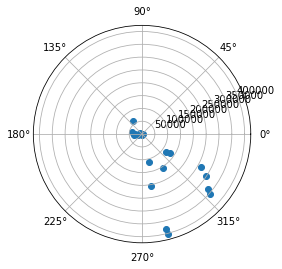

In [93]:
r = np.array(ini_state[:3])
v = np.array(ini_state[3:])
rot = tele_trans_LVLH(r, v)

theta_tmp = []
phi_tmp = []
R_tmp = []
polar_tmp = []

for i in range(len(obs_target)):
    r_t = obs_target1[i][:3]
    r_v = obs_target1[i][3:]
    R, theta, phi = target_trans_LVLH(r, v, rot, r_t, r_v)

    R_tmp.append(R)
    theta_tmp.append(theta)
    phi_tmp.append(phi)
    polar = abs(R * np.sin((theta*np.pi)/180))
    polar_tmp.append(polar)

print(theta_tmp)
print(polar_tmp)

plt.figure()
ax1 = plt.subplot(111, projection='polar')
ax1.scatter(phi_tmp, polar_tmp)
plt.show()

In [38]:
from scipy.io import savemat
import numpy as np


file_name = 'obs_simulation_rv.mat'
savemat(file_name, {'obs_target1': obs_target1})

In [39]:
import scipy.io as scio

dataFile = 'D:/Satellite Orbit Modeling1/Satellite Orbit Modeling/more_eph.mat'
data = scio.loadmat(dataFile)
more_eph = data['more_eph']


In [56]:
more_eph.shape

(21, 241, 6)

[-255672.94231988  448791.93751777 -626023.75221457]
111265.91731385514
36607.33691589319
[-130220.08663966  211573.46849997 -289551.23423611]
59591.09697717054
8860.329349514504
[-327333.32635975  559162.74008946 -789337.39548241]
147833.48844901778
47570.69323233311
[ -634923.34690636  1097589.68183503 -1543800.3609439 ]
282689.6152196001
93339.41515545757
[ -841252.57694623  1421362.32105329 -2014198.9968679 ]
385026.1555741562
121615.65406697243
[ -441370.67765273  1286801.34705837 -1425263.73774498]
2150.6837391354493
681.0641491399147
[ -531202.54126739  1552229.51386377 -1717774.53430652]
1290.8327118813177
425.6829414393287
[-241746.2059082   417448.05562022 -584936.0475484 ]
107318.5604805935
33896.76353118557
[ -439915.29574097   759703.16104695 -1063946.67808313]
195171.89757593628
61329.15799550526
[ -506496.10877524  1560315.14731124 -1692108.85371511]
-28507.259568352718
-9256.7712802866
[ -749738.12356783  1293559.44984245 -1819686.53605962]
334437.7039753152
109465.6531

17458.82039168733
[ -264108.71311979   888525.86752437 -1089911.54337607]
-22782.07452808018
90440.9773808776
[ -507313.08004061  1654999.93545437 -1624025.45570094]
-104450.38275974349
-108771.36145290127
[ -604677.88393326  1276721.46302399 -1852620.01106974]
210289.07035391906
211210.14910765318
[ -536663.78008666   933265.66042691 -1221133.09033937]
209046.5055581951
20103.632307787542
[ -22951.58372104  563475.34152585 -633680.25720472]
-147094.18129403098
89177.72443452175
[ -466217.68855772  1418668.50220208 -1458259.40088698]
-50854.17888742831
-64485.41593946295
[ 101969.88867626  335745.14983916 -228571.64653652]
-212797.61754733406
10174.699449989654
[-151036.10816686  629555.19145135 -592491.51400941]
-79812.36119399831
-37850.12440138479
[ -598638.38991164  1822122.75929072 -2034417.77924331]
-35641.43521165912
24512.251919191098
[ -677468.68771625  1548490.79069775 -2072767.01994968]
175665.0406552269
167527.3022994327
[ -569288.00257122  1254134.97871067 -1796146.5766221

[ -261446.63438478  1726500.09521546 -1558973.31722424]
-374683.86231802433
-73561.0921863257
[-278642.32921615  517164.64969607 -650028.3817304 ]
89558.82912715425
2514.3014724272653
[ -104322.79365968  1005740.48336766 -1113625.95969538]
-221698.81538045564
116900.87331173732
[ -508111.27356879  1741226.36939697 -1562306.32883699]
-173669.97688150068
-199235.29042991588
[ -472854.91958642  1261574.14232115 -1882720.76573682]
97617.11353672983
303696.3257445893
[ -539188.11624617   968451.6590109  -1167988.90496878]
173500.1516632957
-36450.386998405564
[ 111744.80090473  596411.27563126 -689893.12667753]
-272469.64075507363
173037.09378882154
[ -466134.54922695  1428640.26909606 -1385535.37473541]
-82321.40780746998
-118434.74949690886
[ 249593.54089138  470831.34813359 -251342.1658713 ]
-403918.2421941061
19943.204049570923
[ -35061.519088    766667.9886085  -517167.10017191]
-266210.2738382179
-109737.76816497423
[ -599887.88686166  1796990.6267589  -2063551.83594255]
-34346.481428

-90649.39301266032
[  -27926.36430926  1615982.17897106 -1148482.4199385 ]
-604936.4855340926
-170235.6955641592
[  -94589.80709327  1834683.17829923 -1461032.82662209]
-606584.3526923017
-119359.17313547793
[-301523.10839874  579034.47663425 -690472.50748483]
76905.67843429191
-16913.621034298325
[  103327.32073072  1158265.16344035 -1144619.98703325]
-481350.31125635834
151289.108752599
[ -509231.5633679   1853528.48444346 -1482327.54271873]
-263902.652299345
-316827.1346938298
[ -301567.00974115  1242108.39146274 -1922078.39683362]
-48561.6127523543
423909.7461805942
[ -542516.72376943  1014355.98392436 -1099079.29178824]
127520.17976354476
-109968.01038832939
[ 286791.86751262  639317.32735069 -763068.48864894]
-436019.08338431385
282039.5729506198
[ -466097.47760338  1441790.23621601 -1291217.24873485]
-122385.35820059173
-188561.53908558795
[ 441456.28441621  646476.16967932 -281004.41496568]
-653641.1011496363
32638.788025639165
[ 115657.56325368  944992.80185237 -419360.5729503

[-168357.39963935  368768.4759581    65719.05032623]
-60960.11409871932
-335104.84937230515
[ 329249.47778882 1154657.71614459 -586694.22352801]
-776284.4238471978
-107862.87409439503
[   48564.06202346  1661281.25211648 -1757555.0880548 ]
-607305.6453029179
245677.62108905544
[ -932466.33834899  1917194.57427753 -2054413.82067016]
132501.19750861073
-178047.4387126062
[  142115.83978673  1751895.1063743  -1035003.33313395]
-853790.2704785407
-240597.61623700848
[   84968.51747806  1951427.79925974 -1355874.83234626]
-855522.9522732783
-168673.2757002992
[-326204.66537162  645792.65681655 -734170.67846735]
61851.409068753564
-37834.33115825808
[  326836.56506765  1322705.25480776 -1178219.10378888]
-762251.0755953524
188307.79062505357
[ -510547.5858454  1974725.1097994 -1396530.1202437]
-361375.4640769367
-443442.35669683374
[ -117221.69858012  1221428.021299   -1964746.01614505]
-205579.14716592367
553338.3760695612
[ -546162.5844896   1063989.59064701 -1025097.56073357]
78301.562476

[-180285.28022758  417942.91445093  176585.01072025]
-96774.42968939271
-442524.9005280258
[ 534196.11784872 1341030.97530581 -523806.12350515]
-1065866.2674205438
-156424.76039242977
[  261822.81916165  1838082.94097672 -1825093.44403826]
-889875.013946068
293240.2626406598
[ -961238.11881182  2072945.65111545 -2067891.87397156]
48643.4246446215
-271675.204264326
[ 324146.99573013 1897725.14252776 -913745.53454587]
-1119570.1666842632
-315965.61008677084
[  277179.96835858  2076768.87144231 -1243573.97235226]
-1121242.6952155144
-221497.60039836867
[-352702.75962948  717476.60520465 -781170.369407  ]
44069.37412947198
-60245.24931974517
[  566149.09922955  1499099.55114278 -1214488.10437964]
-1064601.4505924156
227950.26773636707
[ -512090.46492132  2104864.26531201 -1305001.15904721]
-466137.31101264496
-579065.6809377426
[   80134.83017993  1199592.4075698  -2010781.03234766]
-373301.60865301575
691963.8928147748
[-550141.63787834 1117386.90179014 -946099.55673623]
25920.07516828386

-1313865.1151798712
-371218.3066265206
[  418009.78893718  2168843.30567324 -1161464.9965558 ]
-1315395.9267866453
-260224.6768233647
[-372174.34349258  770153.56425822 -815765.11135624]
29936.74568885335
-76675.85556223022
[  741519.64473921  1628591.32930811 -1241272.71563581]
-1287183.6553942407
257005.9481544234
[ -513313.59191139  2200481.88466684 -1238149.02836271]
-543166.3598739803
-678492.7248898268
[  224747.61240374  1183789.1367124  -2044746.84359208]
-495934.5888227332
793583.8982051197
[-553108.89215591 1156682.46749639 -888347.1770915 ]
-12255.046296327026
-336101.87974181585
[ 824791.89023913  771996.4894919  -988948.14062645]
-942819.8370418858
617235.1069402345
[ -466493.43270489  1483473.55352104 -1002583.6652728 ]
-239610.80342548765
-404233.378649981
[1031218.32107149 1187160.40871155 -372869.30651841]
-1430342.7223896068
71666.05905341104
[ 578912.15206814 1494100.58666724 -119351.68877381]
-1254685.775274232
-490582.5046143193
[ -607602.32085317  1666590.78778918

[ 834485.43373115 1614569.32758722 -432000.89463987]
-1490923.812636635
-227621.38137701614
[  574211.23341052  2097957.02710724 -1924851.06894177]
-1307888.1240645756
362948.9113820456
[-1003709.08442262  2302083.59778957 -2088519.97224743]
-78617.78462943377
-408957.6998339046
[ 590789.48095081 2111955.3672266  -736528.18380549]
-1507602.3501714051
-426453.15845152485
[  558724.23624698  2261041.8487388  -1079565.52079725]
-1508910.1626132908
-298940.4619412556
[-391683.11031758  822926.54294406 -850476.0780761 ]
14874.87932772639
-93101.98389286269
[  916769.3193753   1758197.29712599 -1268223.59060406]
-1510451.4678099374
286046.96082071227
[ -514617.75816677  2296249.34833045 -1171531.07233184]
-620359.0157406925
-777889.2388717525
[  369252.83873186  1168161.48229872 -2078884.94528515]
-618237.9494733731
895165.4764630732
[-556118.94714142 1196089.59988536 -830749.20940939]
-50223.99422794151
-398253.729070588
[  972529.27999301   808665.06972472 -1051263.95058137]
-1083024.71885

-476648.63945966325
[  686539.20338493  2344959.33537397 -1005294.93075377]
-1684247.2529512562
-334125.1584528007
[-409453.46259615  870988.22967495 -882138.09686009]
372.1886489609169
-108030.17907153489
[ 1075971.21929124  1876119.36205856 -1292874.48964306]
-1713986.415975897
312433.99172100844
[ -515876.33478237  2383437.4279797  -1111177.39367059]
-690669.517731548
-868219.3841345549
[  500520.33110102  1154105.68064453 -2110067.04820695]
-729120.0258010146
987474.6988176994
[-558893.31248133 1232007.43454897 -778523.34094065]
-84558.63885491082
-454736.72743966925
[ 1106737.73085245   842070.60332573 -1107991.80074715]
-1210756.4726545154
793029.122762809
[-467012.05697666 1506021.92453715 -851999.12364552]
-297449.1891804581
-517361.0075221339
[1340319.17013645 1471168.54619485 -421576.0485341 ]
-1842679.8691712078
92125.84721645416
[ 821707.60734034 1782536.0196267    37502.84103587]
-1645948.2856102535
-641329.9786117831
[ -611216.82744686  1616240.94151371 -2284939.39730931]

874638.3687522153
[-318495.65242864  422729.84950431 -400806.40942923]
91098.8877263499
-128616.7854100038
[-214434.18295425  558806.45465485  493952.84569091]
-194300.4124024704
-750086.4537679767
[1120719.67517143 1875847.34055435 -344887.609215  ]
-1896767.955518548
-295537.7937514678
[  871887.07749573  2346649.86716788 -2020900.37975869]
-1710679.8678614218
429424.50133629923
[-1044585.23487608  2521593.42962821 -2109221.01147643]
-204841.47956996365
-539940.8177006666
[ 844883.38534192 2316774.07601102 -568082.54357521]
-1875780.172269565
-531841.0117715221
[ 827009.73928845 2437371.38509197 -923800.98745738]
-1876440.69175668
-372813.8302231005
[-429042.71456654  923954.09675505 -917089.8718947 ]
-16476.048107935756
-124445.25556961971
[ 1250953.55141869  2005941.24805096 -1320162.01463728]
-1938461.6238783954
341443.19215249585
[ -517344.00067215  2479480.1221139  -1045022.67724044]
-768152.6465352145
-967544.9704203318
[  644795.182529    1138809.22057233 -2144527.30331532]
-8

-584565.1301135935
[ 1415013.09272788   919163.95144096 -1238751.82153642]
-1505421.1392670977
985363.1155111976
[-467825.61075971 1531175.11446091 -687818.38616069]
-357821.6509430088
-641147.6204785809
[1678293.4530882  1782347.03680031 -475402.83320336]
-2297485.882345824
114504.3002000653
[1087196.50126489 2098476.17160013  208703.18062745]
-2073708.3732601055
-806274.8602813715
[ -615577.72043891  1561965.92710257 -2355850.1836524 ]
-28272.117921635858
377912.87502475735
[  782356.22934644  2651099.51983616 -2715770.14917554]
-1730640.3525511525
674408.0310512728
[  808125.24826223  1499039.64527476 -2463196.96530186]
-1156163.0382779343
1174780.5512956562
[ 1122864.81033345  1045879.7616509  -1557998.05561423]
-1290298.009253584
983800.4467399648
[-326311.97889095  419919.64601642 -373648.30821703]
89996.34188130105
-148846.37914730227
[-224729.49216197  601315.36655645  589762.46130976]
-222235.49427069625
-842920.3167759122
[1297678.6239324  2037657.49755635 -291234.10173832]
-

[-521020.87335247 2698267.73906844 -895614.65727685]
-944760.9204111885
-1193114.873943288
[  972179.6712957   1104679.602522   -2223456.34025079]
-1125667.8053922579
1319428.8912922523
[-569191.37624238 1361994.41586732 -591609.59421826]
-206670.86660237017
-657885.7125281083
[ 1588974.89799701   962902.85170056 -1312840.79933778]
-1672446.781394866
1093962.3723648493
[-468398.25857236 1545581.86580385 -595364.00186067]
-390554.14719931665
-711048.7840242871
[1869014.70586485 1958288.2677407  -506081.48207519]
-2555901.080011127
127137.22531545558
[1237023.51033841 2277040.02284401  305168.93551529]
-2314991.536699144
-899414.5225662049
[ -618239.58684528  1531694.47057186 -2396376.39461701]
-28531.113260877668
420775.8067116942
[  958786.79133238  2786418.8233601  -2795535.91577367]
-1969291.0110192194
735851.1487288049
[  974654.48662178  1530000.58577646 -2545481.96985826]
-1321120.6307239237
1292498.0845051664
[ 1292678.04493581  1016535.55041307 -1573233.79603069]
-1424494.411382

[1323850.4234123  2765754.56631502 -636618.06438621]
-2551587.124660904
-509829.7835168325
[ -498903.26629237  1112616.90353362 -1042152.21941223]
-83836.85875102664
-182581.35435771628
[ 1869973.8377434   2467116.46389193 -1418458.72292847]
-2738743.829597329
444135.14448126685
[-523298.44185014 2821083.97630291 -812539.02429047]
-1043943.6031792434
-1319315.2021983217
[ 1155171.86532058  1085947.40421819 -2268018.23154837]
-1278661.226046619
1448342.2498947936
[-573332.14404882 1412810.0694564  -519398.12474588]
-253504.0658860542
-736788.5329229467
[ 1776063.70732292  1010142.1816825  -1392779.58796361]
-1852645.372995078
1210813.14129446
[-469105.14297322 1561234.36595667 -496074.29081323]
-424669.55470365344
-786265.4683946641
[2074125.68724282 2147810.98672605 -539348.4809944 ]
-2835194.8275995655
140727.85795493523
[1398164.55907495 2469311.59829477  408794.62734206]
-2574335.1583923046
-999634.467586902
[ -621273.39642191  1499424.59922144 -2440382.75261183]
-29144.305010323238

[-525203.9522359  2917724.29118338 -747574.29172713]
-1122000.9335124565
-1418404.8630549225
[ 1298762.28239815  1071418.40304179 -2303208.89531909]
-1398346.8737376635
1549549.1232376655
[-576640.86884801 1452831.31444226 -462853.10638705]
-290034.49115369323
-798736.5960297969
[ 1922861.29937044  1047359.31193005 -1455700.71939493]
-1994433.0881655584
1302543.2481079586
[-469725.44658734 1573623.99818535 -418261.68722287]
-450642.31546679913
-845314.484844505
[2235061.90071733 2296756.7679758  -565665.46815829]
-3055317.697194798
151395.28076507425
[1524608.48363183 2620351.2990709   490014.90047577]
-2777685.383287989
-1078310.9684954868
[ -623783.30503513  1474311.2841438  -2475224.47990336]
-29880.966212323343
503132.58781600534
[ 1297314.27901365  3047491.81031928 -2950044.05931463]
-2432106.929015591
853895.0557939552
[ 1294225.34661397  1590291.80951095 -2704508.94063932]
-1639516.398303533
1518640.9015931184
[ 1618624.11846611   960547.27621601 -1602992.00728737]
-1679359.2040

[1568016.52399386 2903157.02083272  -90869.88766661]
-2913377.9635662576
-832335.5585374242
[1590510.08054928 2942954.78021267 -483136.08122127]
-2910648.2178007015
-583484.5023081219
[ -536828.11495804  1214804.02539036 -1110307.43361844]
-125090.33920217675
-213835.43732801126
[ 2202260.1301035   2716013.31337345 -1472467.54416967]
-3172105.369660369
499313.92338151834
[-527028.06144506 3005683.77143648 -688756.99334415]
-1193052.4107274243
-1508430.415242671
[ 1429145.69939822  1058353.37949099 -2335333.76623532]
-1506732.4594889937
1641487.4543918343
[-579691.78651674 1489282.31850261 -411597.86845167]
-323035.6124795814
-855013.5793773376
[ 2056149.42410913  1081270.93628659 -1512989.11954449]
-2123462.6356950444
1385867.4850465828
[-470338.29292794 1584950.69337294 -347675.93801249]
-473613.74773906154
-898953.7033453744
[2381185.20383632 2432189.12977058 -589735.10198522]
-3255911.7873476143
161084.10760689422
[1639420.60441291 2757629.23684932  563691.44574302]
-2962188.8640462

[2084464.77319417 2759923.61154055  -54715.52607666]
-3265814.075459834
-524650.4029306633
[ 1873489.73505771  3192087.29008786 -2352292.24458093]
-3097133.417903103
653587.8721023732
[-1185721.37872546  3269528.30133335 -2187303.67208504]
-666115.3427114335
-982136.4136005703
[1700052.61780115 3010767.16533284   -4064.4021478 ]
-3100942.7898257244
-887298.2192039037
[1729917.26204982 3035851.02663398 -403070.37486265]
-3097353.277655529
-622024.129848116
[ -556792.52164702  1268507.09054927 -1146256.27289626]
-148107.0514174768
-230190.12576161488
[ 2375985.81673247  2846545.24474096 -1501081.48162858]
-3399670.150737874
528180.595475676
[-529138.924873   3102550.6076681  -624329.34493136]
-1271300.6968610513
-1607392.7097194374
[ 1572389.76881799  1044138.04621605 -2370815.40418197]
-1625474.924920415
1742539.6559352018
[-583095.85217779 1529448.98269366 -355383.68118961]
-359103.16531096736
-916871.2671156095
[ 2202574.679188    1118660.4565727  -1576104.29514606]
-2265516.194676252

[1869125.44443506 3128788.02474688 -323234.2760882 ]
-3283060.72161453
-660532.2515438104
[ -576830.74299149  1322335.00347892 -1182384.7061164 ]
-172098.4603048548
-246532.448830895
[ 2549468.42262104  2977184.39362632 -1529927.05717503]
-3627575.4628550704
557020.6304380981
[-531362.65653429 3199530.25790739 -560191.98588719]
-1349636.9611108468
-1706281.588955624
[ 1715438.11997823  1030085.0101728  -2406445.6404834 ]
-1743691.3872805168
1843502.5104561765
[-586551.05376897 1569685.01847426 -299346.45913232]
-394921.14234459645
-978675.8852501716
[ 2348787.53368391  1156141.92500635 -1639324.0197454 ]
-2407671.593843096
1568937.5440540456
[-471847.44989571 1610055.69252121 -192898.89459582]
-521985.0810929966
-1016804.5237241146
[2701994.03966594 2730232.42687048 -643210.27996157]
-3698691.0536723747
182368.00090582535
[1891508.95729428 3059507.07782621  725212.27270238]
-3366722.959911902
-1306800.9628518752
[ -631751.70253254  1402473.81403194 -2577921.09922267]
-33388.56911793904

[-288201.1250905   864374.60354433 1185086.42591043]
-379050.7682408717
-1418905.903384292
[2394978.20204501 3046367.48103187   37637.94951752]
-3706964.51338714
-598637.8011435461
[ 2195987.28442553  3467503.41693176 -2462071.22428826]
-3553513.4114376716
725972.2942104666
[-1232593.50723414  3513754.3093782  -2215532.9895384 ]
-827037.1349003719
-1125097.8174509115
[1975504.19228645 3235788.33913037  176720.24131285]
-3490081.427153105
-1002060.5855492395
[2020750.7650621  3230209.07801298 -236404.97987881]
-3484464.632807543
-702502.3770220629
[ -598780.17047521  1381201.78455118 -1222010.2500833 ]
-199388.9020179056
-264345.43192376685
[ 2738429.75863384  3119821.20142751 -1561667.41651717]
-3876543.884392702
588450.7467023474
[-533921.6618304  3305450.15643749 -490562.3370759 ]
-1435185.2265197842
-1814071.2145037695
[ 1871255.9221493   1014937.92221972 -2445481.34428142]
-1872028.6655666693
1953535.0575285011
[-590379.62259545 1613652.42708509 -238419.79017783]
-433704.8003527263

-3651317.999860606
-737444.3952631355
[ -617147.00380802  1430375.61025526 -1255207.17419801]
-223027.11298876145
-279176.9365433252
[ 2895652.72102014  3238781.23860475 -1588341.30493968]
-4084258.0164788403
614616.1774728447
[-536163.73428994 3393811.82107689 -432813.04355293]
-1506539.9592472678
-1903820.6390508516
[ 2000907.63555788  1002460.38466789 -2478141.26327441]
-1978456.7645602156
2045136.7927374328
[-593618.04027769 1650346.211752   -187813.21447515]
-465788.36210137565
-1102109.7987107006
[ 2640528.01033298  1231384.95080221 -1766085.33785448]
-2692184.213036736
1751639.869460865
[-473571.18872462 1635370.72571485  -38823.24684642]
-567343.3520643756
-1134413.4851343243
[3021804.35392043 3028404.25999628 -697464.10720724]
-4143244.4070713334
203605.3473015941
[2142843.27488073 3361149.51734564  885898.30478214]
-3769079.6433293824
-1463506.19323663
[ -637841.7869197   1354149.07949697 -2649693.16708814]
-37068.07406211147
680621.9625424165
[ 2024561.63594817  3615231.8948

-412955.1950170441
-1560268.6418684463
[2664174.06684392 3295398.88014066  117208.01586931]
-4089110.239884924
-662857.4050139391
[ 2475494.01002374  3707612.48976433 -2558584.26277127]
-3952888.4562336192
788809.3271531286
[-1273885.36052415  3726902.093795   -2241346.72930518]
-971573.3000578827
-1249273.3262563273
[2214285.81154753 3431421.23520595  333112.76421822]
-3824870.7217018884
-1101657.7852533148
[2272874.04091404 3399292.32884639  -92311.41129047]
-3817243.7195392037
-772354.3481214141
[ -635586.46028235  1479658.78369422 -1288569.12724611]
-247484.54356938734
-293996.3473670294
[ 3052642.78943058  3357827.93275162 -1615224.1151739 ]
-4292160.553985378
640756.7757798906
[-538508.52157961 3482256.65334166 -375319.17721573]
-1577946.5568826436
-1993497.9347723005
[ 2130372.56707532   990113.62201755 -2510917.34863164]
-2084394.1493303333
2136650.0460291784
[-596900.65388187 1687085.46598038 -137359.34036524]
-497653.131808143
-1158131.7799115132
[ 2772814.49990152  1265711.5

[-311239.24425441  960609.49810884 1404767.18427791]
-429155.93813784095
-1630790.8564821475
[2798463.45638975 3419885.50859171  156722.19264649]
-4279584.79884122
-694922.2838859513
[ 2614901.09267254  3827882.44131741 -2607222.25901732]
-4153397.1425818168
820188.8117943339
[-1294730.21208101  3833747.86936084 -2254711.19689003]
-1045453.2010178823
-1311308.8322316464
[2333398.65702144 3529204.46723321  411018.11638656]
-3990926.431352778
-1151380.7034209208
[2398645.66453536 3483840.90175437  -20560.03767711]
-3982209.6834745253
-807230.3374499696
[ -654102.24445965  1529053.03176924 -1322101.12538957]
-272765.50718386326
-308803.11483195494
[ 3209390.28472542  3476960.66717014 -1642321.15855449]
-4500223.088966126
666871.7190805972
[-540958.98991234 3570781.5703879  -318085.50442944]
-1649398.6213391256
-2083099.6215952546
[ 2259642.95481138   977896.63333192 -2543807.55246986]
-2189823.446258725
2228070.262937285
[-600228.0228452  1723866.5222713   -87060.17321732]
-529295.2076866

[2461497.81723944 3744618.71178833 1089093.40674045]
-4277456.683762512
-1662428.96917128
[ -646369.72277789  1293914.34553967 -2742435.94197363]
-43382.58387726173
772388.2515800875
[ 2399171.64942835  3911688.99824797 -3467949.97646737]
-3982691.1565158963
1239803.3740870901
[ 2334763.39422584  1795085.3942068  -3233645.22397845]
-2692089.0726868385
2257638.864035532
[ 2680771.37288883   780555.7503795  -1704126.61163487]
-2482393.455622094
1986542.3502718324
[-399373.23281285  396993.58068786 -127594.14860126]
93557.2859535798
-334656.7231877212
[-318081.16130507  989311.61913506 1470575.44987398]
-443300.7155530551
-1694163.3260317245
[2919137.9025774  3531902.0583362   192124.78058852]
-4450633.66329131
-723753.3888661239
[ 2740160.33286167  3936248.22583687 -2651219.80415719]
-4334298.168037019
848407.2585442394
[-1313609.47693036  3930064.26006669 -2267006.61914062]
-1112866.3608212133
-1367109.4458189684
[2440433.53506577 3617181.88786326  480963.73948118]
-4139576.724665157
-1

<ipython-input-57-01c5a6a06052>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(111, projection='polar')


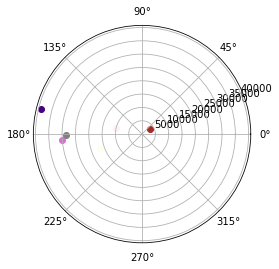

ddddddddddddddddddddddddddddddddd -4.106206345581285
ddddddddddddddddddddddddddddddddd -4.518693004248178
ddddddddddddddddddddddddddddddddd -3.5066637264469875
ddddddddddddddddddddddddddddddddd -3.921503550789339
ddddddddddddddddddddddddddddddddd -4.591356030504301
ddddddddddddddddddddddddddddddddd 3.6794491059850998
ddddddddddddddddddddddddddddddddd 3.746251209840125
ddddddddddddddddddddddddddddddddd -4.2292072019291425
ddddddddddddddddddddddddddddddddd -3.605001323379895
ddddddddddddddddddddddddddddddddd 3.1867921158101638
ddddddddddddddddddddddddddddddddd -4.259770182985676
ddddddddddddddddddddddddddddddddd -4.797314991980727
ddddddddddddddddddddddddddddddddd 2.526026570494423
ddddddddddddddddddddddddddddddddd 3.5755347862862834
ddddddddddddddddddddddddddddddddd -0.289950580587373
ddddddddddddddddddddddddddddddddd -3.212327772298835
ddddddddddddddddddddddddddddddddd 3.375000448458991
ddddddddddddddddddddddddddddddddd -3.9558539286720986
ddddddddddddddddddddddddddddddddd -4.173797434

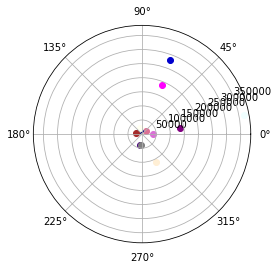

ddddddddddddddddddddddddddddddddd -4.070606221259254
ddddddddddddddddddddddddddddddddd -4.233153287303935
ddddddddddddddddddddddddddddddddd -2.4245749025798204
ddddddddddddddddddddddddddddddddd -3.4394969654688055
ddddddddddddddddddddddddddddddddd -4.422197140590157
ddddddddddddddddddddddddddddddddd 3.13700356728512
ddddddddddddddddddddddddddddddddd 3.3038167237687617
ddddddddddddddddddddddddddddddddd -4.07983339598178
ddddddddddddddddddddddddddddddddd -2.858574669029082
ddddddddddddddddddddddddddddddddd 2.9318881386919315
ddddddddddddddddddddddddddddddddd -4.092381193976109
ddddddddddddddddddddddddddddddddd -4.63047094489346
ddddddddddddddddddddddddddddddddd 1.501611764019458
ddddddddddddddddddddddddddddddddd 3.4226047322572697
ddddddddddddddddddddddddddddddddd -3.8021652934036183
ddddddddddddddddddddddddddddddddd -1.903577124707482
ddddddddddddddddddddddddddddddddd 3.3904388373313736
ddddddddddddddddddddddddddddddddd -3.61511274770848
ddddddddddddddddddddddddddddddddd -3.957791106796

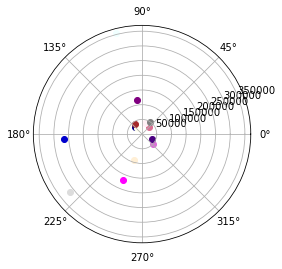

ddddddddddddddddddddddddddddddddd -4.0361858726679145
ddddddddddddddddddddddddddddddddd -4.0951822040743195
ddddddddddddddddddddddddddddddddd -1.3488983748263195
ddddddddddddddddddddddddddddddddd -2.970287359084722
ddddddddddddddddddddddddddddddddd -4.254882797779658
ddddddddddddddddddddddddddddddddd 2.59351078567164
ddddddddddddddddddddddddddddddddd 2.860440343083809
ddddddddddddddddddddddddddddddddd -3.933061073178294
ddddddddddddddddddddddddddddddddd -2.141466083382653
ddddddddddddddddddddddddddddddddd 2.669767006234366
ddddddddddddddddddddddddddddddddd -3.93652363871297
ddddddddddddddddddddddddddddddddd -4.4659304515511735
ddddddddddddddddddddddddddddddddd 0.46356198288290784
ddddddddddddddddddddddddddddddddd 3.262738992959072
ddddddddddddddddddddddddddddddddd -7.098160004188543
ddddddddddddddddddddddddddddddddd -0.592947903976011
ddddddddddddddddddddddddddddddddd 3.4000391709557505
ddddddddddddddddddddddddddddddddd -3.282553326196677
ddddddddddddddddddddddddddddddddd -3.7558612682

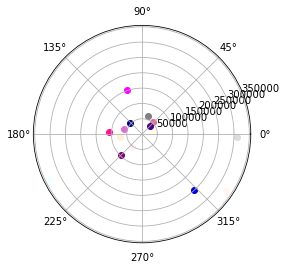

ddddddddddddddddddddddddddddddddd -4.002976929013954
ddddddddddddddddddddddddddddddddd -4.120408109473232
ddddddddddddddddddddddddddddddddd -0.28529293504405473
ddddddddddddddddddddddddddddddddd -2.515909693661854
ddddddddddddddddddddddddddddddddd -4.089460315108937
ddddddddddddddddddddddddddddddddd 2.0490511370288402
ddddddddddddddddddddddddddddddddd 2.4161672213347174
ddddddddddddddddddddddddddddddddd -3.788863442694378
ddddddddddddddddddddddddddddddddd -1.463181672614411
ddddddddddddddddddddddddddddddddd 2.403812224075125
ddddddddddddddddddddddddddddddddd -3.792979941223166
ddddddddddddddddddddddddddddddddd -4.30387481736264
ddddddddddddddddddddddddddddddddd -0.5720680444909476
ddddddddddddddddddddddddddddddddd 3.0987619709042917
ddddddddddddddddddddddddddddddddd -10.177928264423059
ddddddddddddddddddddddddddddddddd 0.7165186502377594
ddddddddddddddddddddddddddddddddd 3.4035833831589173
ddddddddddddddddddddddddddddddddd -2.9590473759290035
ddddddddddddddddddddddddddddddddd -3.569026

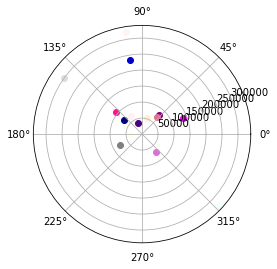

ddddddddddddddddddddddddddddddddd -3.97101115014479
ddddddddddddddddddddddddddddddddd -4.3152936668624875
ddddddddddddddddddddddddddddddddd 0.7545500990541711
ddddddddddddddddddddddddddddddddd -2.0788764493539134
ddddddddddddddddddddddddddddddddd -3.9259801613479226
ddddddddddddddddddddddddddddddddd 1.5037047527205232
ddddddddddddddddddddddddddddddddd 1.9710385739446394
ddddddddddddddddddddddddddddddddd -3.6472155174351713
ddddddddddddddddddddddddddddddddd -0.8374315136861128
ddddddddddddddddddddddddddddddddd 2.135670077946969
ddddddddddddddddddddddddddddddddd -3.662530891242426
ddddddddddddddddddddddddddddddddd -4.144497076602391
ddddddddddddddddddddddddddddddddd -1.6004732010767384
ddddddddddddddddddddddddddddddddd 2.93204775771207
ddddddddddddddddddddddddddddddddd -13.046684976963377
ddddddddddddddddddddddddddddddddd 2.0174510772780536
ddddddddddddddddddddddddddddddddd 3.4009919166277314
ddddddddddddddddddddddddddddddddd -2.6455943558487434
ddddddddddddddddddddddddddddddddd -3.39831

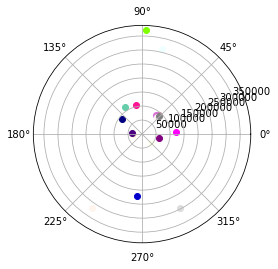

ddddddddddddddddddddddddddddddddd -3.9403203813899097
ddddddddddddddddddddddddddddddddd -4.676017978586145
ddddddddddddddddddddddddddddddddd 1.7405999375681063
ddddddddddddddddddddddddddddddddd -1.6622951023955181
ddddddddddddddddddddddddddddddddd -3.764496169661385
ddddddddddddddddddddddddddddddddd 0.9575524298070945
ddddddddddddddddddddddddddddddddd 1.525095433743786
ddddddddddddddddddddddddddddddddd -3.508094104120488
ddddddddddddddddddddddddddddddddd -0.2838787471750095
ddddddddddddddddddddddddddddddddd 1.8662306951707137
ddddddddddddddddddddddddddddddddd -3.5459425295300377
ddddddddddddddddddddddddddddddddd -3.988002531435882
ddddddddddddddddddddddddddddddddd -2.619546566182379
ddddddddddddddddddddddddddddddddd 2.7633332499839867
ddddddddddddddddddddddddddddddddd -15.713141303169692
ddddddddddddddddddddddddddddddddd 3.2663877345224535
ddddddddddddddddddddddddddddddddd 3.392333224509059
ddddddddddddddddddddddddddddddddd -2.3433387743492347
ddddddddddddddddddddddddddddddddd -3.24473

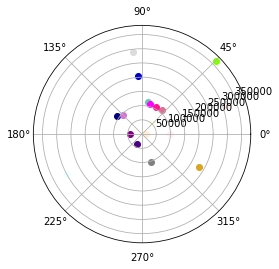

ddddddddddddddddddddddddddddddddd -3.910936506358439
ddddddddddddddddddddddddddddddddd -5.190149373855718
ddddddddddddddddddddddddddddddddd 2.5724644364618996
ddddddddddddddddddddddddddddddddd -1.2699994337274916
ddddddddddddddddddddddddddddddddd -3.6050657556617125
ddddddddddddddddddddddddddddddddd 0.4106756821130091
ddddddddddddddddddddddddddddddddd 1.0783791334989417
ddddddddddddddddddddddddddddddddd -3.3714777909209204
ddddddddddddddddddddddddddddddddd 0.17039566280064378
ddddddddddddddddddddddddddddddddd 1.5960167198094268
ddddddddddddddddddddddddddddddddd -3.4439512217403774
ddddddddddddddddddddddddddddddddd -3.8346092444864155
ddddddddddddddddddddddddddddddddd -3.6281091427253784
ddddddddddddddddddddddddddddddddd 2.5930454568931225
ddddddddddddddddddddddddddddddddd -18.18824834614361
ddddddddddddddddddddddddddddddddd 3.462612341481133
ddddddddddddddddddddddddddddddddd 3.377815995549497
ddddddddddddddddddddddddddddddddd -2.053587390204598
ddddddddddddddddddddddddddddddddd -3.1092

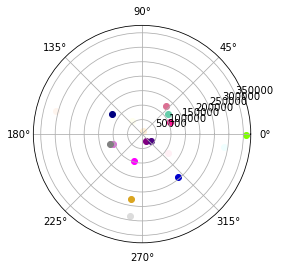

ddddddddddddddddddddddddddddddddd -3.8828913967916208
ddddddddddddddddddddddddddddddddd -5.840068693594731
ddddddddddddddddddddddddddddddddd 2.9014680191894513
ddddddddddddddddddddddddddddddddd -0.9066779312214237
ddddddddddddddddddddddddddddddddd -3.4477501456013613
ddddddddddddddddddddddddddddddddd -0.1368433048507427
ddddddddddddddddddddddddddddddddd 0.6309314062162912
ddddddddddddddddddddddddddddddddd -3.2373469393174616
ddddddddddddddddddddddddddddddddd 0.4918842796618321
ddddddddddddddddddddddddddddddddd 1.3253559488318842
ddddddddddddddddddddddddddddddddd -3.3572473428922365
ddddddddddddddddddddddddddddddddd -3.684548463246273
ddddddddddddddddddddddddddddddddd -4.625385395504168
ddddddddddddddddddddddddddddddddd 2.421447500282113
ddddddddddddddddddddddddddddddddd -20.484215242384096
ddddddddddddddddddddddddddddddddd 2.2524094277198685
ddddddddddddddddddddddddddddddddd 3.3577661188243724
ddddddddddddddddddddddddddddddddd -1.7778245779680049
ddddddddddddddddddddddddddddddddd -2.99

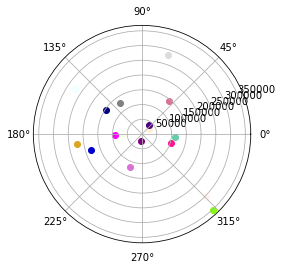

ddddddddddddddddddddddddddddddddd -3.8562168605817533
ddddddddddddddddddddddddddddddddd -6.606473877049609
ddddddddddddddddddddddddddddddddd 2.4209327026392486
ddddddddddddddddddddddddddddddddd -0.577961770045988
ddddddddddddddddddddddddddddddddd -3.2926146128893947
ddddddddddddddddddddddddddddddddd -0.6849217413954705
ddddddddddddddddddddddddddddddddd 0.18279440170726957
ddddddddddddddddddddddddddddddddd -3.1056836712543827
ddddddddddddddddddddddddddddddddd 0.6478585743362828
ddddddddddddddddddddddddddddddddd 1.0544654329042373
ddddddddddddddddddddddddddddddddd -3.28645820570776
ddddddddddddddddddddddddddddddddd -3.5380649495241983
ddddddddddddddddddddddddddddddddd -5.610809632235487
ddddddddddddddddddddddddddddddddd 2.248709712664123
ddddddddddddddddddddddddddddddddd -22.61376856765935
ddddddddddddddddddddddddddddddddd 0.9644158545099515
ddddddddddddddddddddddddddddddddd 3.3325940094167947
ddddddddddddddddddddddddddddddddd -1.5177231215960205
ddddddddddddddddddddddddddddddddd -2.8962

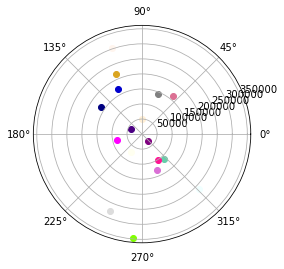

ddddddddddddddddddddddddddddddddd -3.830944586397635
ddddddddddddddddddddddddddddddddd -7.47087456720962
ddddddddddddddddddddddddddddddddd 1.5506519184655758
ddddddddddddddddddddddddddddddddd -0.29040326321722887
ddddddddddddddddddddddddddddddddd -3.1397287229049198
ddddddddddddddddddddddddddddddddd -1.2334763074554473
ddddddddddddddddddddddddddddddddd -0.26598932080739246
ddddddddddddddddddddddddddddddddd -2.976471867167106
ddddddddddddddddddddddddddddddddd 0.6204513246243835
ddddddddddddddddddddddddddddddddd 0.7834956269621784
ddddddddddddddddddddddddddddddddd -3.2321310614986203
ddddddddddddddddddddddddddddddddd -3.395417185242138
ddddddddddddddddddddddddddddddddd -6.583942740459179
ddddddddddddddddddddddddddddddddd 2.074946876646891
ddddddddddddddddddddddddddddddddd -24.58961972873618
ddddddddddddddddddddddddddddddddd -0.32994589593184287
ddddddddddddddddddddddddddddddddd 3.3027592215708523
ddddddddddddddddddddddddddddddddd -1.275146432353921
ddddddddddddddddddddddddddddddddd -2.82

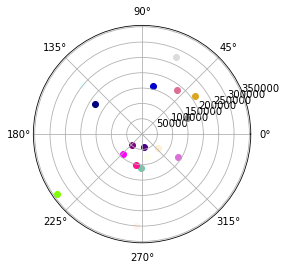

ddddddddddddddddddddddddddddddddd -3.807106087554075
ddddddddddddddddddddddddddddddddd -8.416876183040273
ddddddddddddddddddddddddddddddddd 0.5683874852187216
ddddddddddddddddddddddddddddddddd -0.05124049425899102
ddddddddddddddddddddddddddddddddd -2.989166582424957
ddddddddddddddddddddddddddddddddd -1.782423230615649
ddddddddddddddddddddddddddddddddd -0.7153768109921828
ddddddddddddddddddddddddddddddddd -2.849697152616102
ddddddddddddddddddddddddddddddddd 0.41770883612005605
ddddddddddddddddddddddddddddddddd 0.5125550309257108
ddddddddddddddddddddddddddddddddd -3.194717145319828
ddddddddddddddddddddddddddddddddd -3.2568774155163567
ddddddddddddddddddddddddddddddddd -7.544431973647988
ddddddddddddddddddddddddddddddddd 1.9002389459341202
ddddddddddddddddddddddddddddddddd -26.42410197324125
ddddddddddddddddddddddddddddddddd -1.6214698025068799
ddddddddddddddddddddddddddddddddd 3.2687382351822407
ddddddddddddddddddddddddddddddddd -1.0521367838475726
ddddddddddddddddddddddddddddddddd -2.76

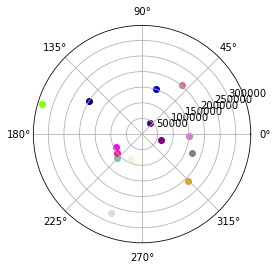

ddddddddddddddddddddddddddddddddd -3.7847326447086687
ddddddddddddddddddddddddddddddddd -9.430562697194176
ddddddddddddddddddddddddddddddddd -0.4504878903529459
ddddddddddddddddddddddddddddddddd 0.13216731996064368
ddddddddddddddddddddddddddddddddd -2.8410070945928396
ddddddddddddddddddddddddddddddddd -2.331678365265759
ddddddddddddddddddddddddddddddddd -1.1653247454479185
ddddddddddddddddddddddddddddddddd -2.725346891879269
ddddddddddddddddddddddddddddddddd 0.06942739833766609
ddddddddddddddddddddddddddddddddd 0.2417246607828929
ddddddddddddddddddddddddddddddddd -3.1745578015574836
ddddddddddddddddddddddddddddddddd -3.1227314944283364
ddddddddddddddddddddddddddddddddd -8.491989559339629
ddddddddddddddddddddddddddddddddd 1.724643175664994
ddddddddddddddddddddddddddddddddd -28.128938953122372
ddddddddddddddddddddddddddddddddd -2.906849774513347
ddddddddddddddddddddddddddddddddd 3.230998957254883
ddddddddddddddddddddddddddddddddd -0.850882976074189
ddddddddddddddddddddddddddddddddd -2.73

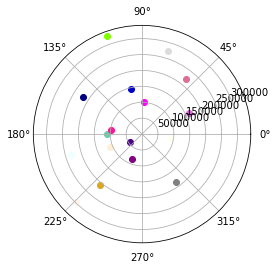

ddddddddddddddddddddddddddddddddd -3.7638552385817263
ddddddddddddddddddddddddddddddddd -10.500375707940123
ddddddddddddddddddddddddddddddddd -1.4821773686316249
ddddddddddddddddddddddddddddddddd 0.2532838747332278
ddddddddddddddddddddddddddddddddd -2.6953342088604586
ddddddddddddddddddddddddddddddddd -2.8811572765744415
ddddddddddddddddddddddddddddddddd -1.615789462664992
ddddddddddddddddddddddddddddddddd -2.603410172125109
ddddddddddddddddddddddddddddddddd -0.3875474942652204
ddddddddddddddddddddddddddddddddd -0.028933083400744408
ddddddddddddddddddddddddddddddddd -3.1718736728363695
ddddddddddddddddddddddddddddddddd -2.9932784807699875
ddddddddddddddddddddddddddddddddd -9.426380295048546
ddddddddddddddddddddddddddddddddd 1.5482015324528504
ddddddddddddddddddddddddddddddddd -29.71511141972482
ddddddddddddddddddddddddddddddddd -4.18415246587
ddddddddddddddddddddddddddddddddd 3.1899830506153535
ddddddddddddddddddddddddddddddddd -0.6736605443486212
ddddddddddddddddddddddddddddddddd -2.7

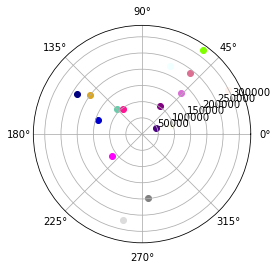

ddddddddddddddddddddddddddddddddd -3.744504501948086
ddddddddddddddddddddddddddddddddd -11.616783089973922
ddddddddddddddddddddddddddddddddd -2.51701310287379
ddddddddddddddddddddddddddddddddd 0.30758541369195314
ddddddddddddddddddddddddddddddddd -2.552237173181311
ddddddddddddddddddddddddddddddddd -3.430775318297492
ddddddddddddddddddddddddddddddddd -2.0667269804049226
ddddddddddddddddddddddddddddddddd -2.483877795487757
ddddddddddddddddddddddddddddddddd -0.9207357086353909
ddddddddddddddddddddddddddddddddd -0.2993687786112105
ddddddddddddddddddddddddddddddddd -3.1867577743522872
ddddddddddddddddddddddddddddddddd -2.868829943537378
ddddddddddddddddddddddddddddddddd -10.347413722990524
ddddddddddddddddddddddddddddddddd 1.370945392079932
ddddddddddddddddddddddddddddddddd -31.19279400063286
ddddddddddddddddddddddddddddddddd -5.451931266740871
ddddddddddddddddddddddddddddddddd 3.146095475904019
ddddddddddddddddddddddddddddddddd -0.5227392047808621
ddddddddddddddddddddddddddddddddd -2.7293

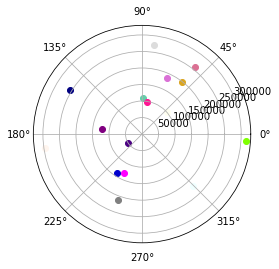

ddddddddddddddddddddddddddddddddd -3.7267106435049016
ddddddddddddddddddddddddddddddddd -12.771903285588905
ddddddddddddddddddddddddddddddddd -3.5502159560765847
ddddddddddddddddddddddddddddddddd 0.29361868403503877
ddddddddddddddddddddddddddddddddd -2.411810780332246
ddddddddddddddddddddddddddddddddd -3.9804477246319436
ddddddddddddddddddddddddddddddddd -2.518093018036325
ddddddddddddddddddddddddddddddddd -2.3667422664954927
ddddddddddddddddddddddddddddddddd -1.5057021303358908
ddddddddddddddddddddddddddddddddd -0.5695422757752056
ddddddddddddddddddddddddddddddddd -3.2191729981428523
ddddddddddddddddddddddddddddddddd -2.7497089307397005
ddddddddddddddddddddddddddddddddd -11.254938769022345
ddddddddddddddddddddddddddddddddd 1.1928986171836584
ddddddddddddddddddddddddddddddddd -32.57134036685238
ddddddddddddddddddddddddddddddddd -6.708972333602162
ddddddddddddddddddddddddddddddddd 3.099699760199485
ddddddddddddddddddddddddddddddddd -0.40025671944792407
ddddddddddddddddddddddddddddddddd 

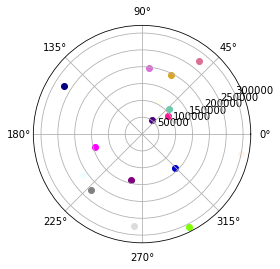

ddddddddddddddddddddddddddddddddd -3.710503388723879
ddddddddddddddddddddddddddddddddd -13.959161151380584
ddddddddddddddddddddddddddddddddd -4.579039805540873
ddddddddddddddddddddddddddddddddd 0.2134539136496585
ddddddddddddddddddddddddddddddddd -2.2741555930490733
ddddddddddddddddddddddddddddddddd -4.530089683663078
ddddddddddddddddddddddddddddddddd -2.969843028421593
ddddddddddddddddddddddddddddddddd -2.2519977860907545
ddddddddddddddddddddddddddddddddd -2.1252974037611523
ddddddddddddddddddddddddddddddddd -0.8394202067961203
ddddddddddddddddddddddddddddddddd -3.268954228036961
ddddddddddddddddddddddddddddddddd -2.636248550040449
ddddddddddddddddddddddddddddddddd -12.148839791190767
ddddddddddddddddddddddddddddddddd 1.014079623346504
ddddddddddddddddddddddddddddddddd -33.85930042996003
ddddddddddddddddddddddddddddddddd -7.95420426209057
ddddddddddddddddddddddddddddddddd 3.05111730498777
ddddddddddddddddddddddddddddddddd -0.3080661748350053
ddddddddddddddddddddddddddddddddd -2.811998

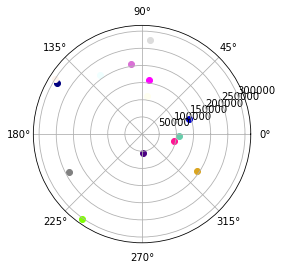

ddddddddddddddddddddddddddddddddd -3.6959119152240874
ddddddddddddddddddddddddddddddddd -15.17300121151257
ddddddddddddddddddddddddddddddddd -5.601710331156994
ddddddddddddddddddddddddddddddddd 0.07229082864367342
ddddddddddddddddddddddddddddddddd -2.139378150980747
ddddddddddddddddddddddddddddddddd -5.079616420161727
ddddddddddddddddddddddddddddddddd -3.4219322255374323
ddddddddddddddddddddddddddddddddd -2.1396402288238505
ddddddddddddddddddddddddddddddddd -2.7677487289333556
ddddddddddddddddddddddddddddddddd -1.1089742610571705
ddddddddddddddddddddddddddddddddd -3.3358148833176244
ddddddddddddddddddddddddddddddddd -2.5287900906683944
ddddddddddddddddddddddddddddddddd -13.029033443210068
ddddddddddddddddddddddddddddddddd 0.8345028047319829
ddddddddddddddddddddddddddddddddd -35.06445751026081
ddddddddddddddddddddddddddddddddd -9.186661193686149
ddddddddddddddddddddddddddddddddd 3.0006292560952943
ddddddddddddddddddddddddddddddddd -0.2475737513086358
ddddddddddddddddddddddddddddddddd -2

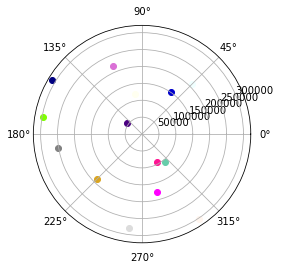

ddddddddddddddddddddddddddddddddd -3.682964787839893
ddddddddddddddddddddddddddddddddd -16.408660350556204
ddddddddddddddddddddddddddddddddd -6.61697228315532
ddddddddddddddddddddddddddddddddd -0.12259032392438485
ddddddddddddddddddddddddddddddddd -2.0075911476598094
ddddddddddddddddddddddddddddddddd -5.628943282366521
ddddddddddddddddddddddddddddddddd -3.8743156125668463
ddddddddddddddddddddddddddddddddd -2.0296671221174165
ddddddddddddddddddddddddddddddddd -3.424958036390251
ddddddddddddddddddddddddddddddddd -1.3781799692744698
ddddddddddddddddddddddddddddddddd -3.41935734670065
ddddddddddddddddddddddddddddddddd -2.42768069153351
ddddddddddddddddddddddddddddddddd -13.8954660395583
ddddddddddddddddddddddddddddddddd 0.6541795382836995
ddddddddddddddddddddddddddddddddd -36.19387696897732
ddddddddddddddddddddddddddddddddd -10.405466260181527
ddddddddddddddddddddddddddddddddd 2.9484797936584073
ddddddddddddddddddddddddddddddddd -0.21959308300520775
ddddddddddddddddddddddddddddddddd -2.975

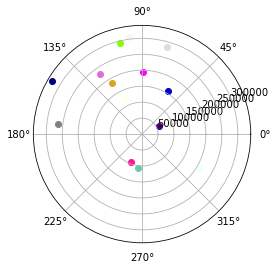

ddddddddddddddddddddddddddddddddd -3.6716898937325197
ddddddddddddddddddddddddddddddddd -17.661992675421203
ddddddddddddddddddddddddddddddddd -7.623874932478344
ddddddddddddddddddddddddddddddddd -0.36306285061749577
ddddddddddddddddddddddddddddddddd -1.878913567227329
ddddddddddddddddddddddddddddddddd -6.1779858248311825
ddddddddddddddddddddddddddddddddd -4.326948010384854
ddddddddddddddddddddddddddddddddd -1.9220776230804404
ddddddddddddddddddddddddddddddddd -4.091279739298301
ddddddddddddddddddddddddddddddddd -1.647015828947957
ddddddddddddddddddddddddddddddddd -3.5190864743385077
ddddddddddddddddddddddddddddddddd -2.3332705013455666
ddddddddddddddddddddddddddddddddd -14.748111241183068
ddddddddddddddddddddddddddddddddd 0.47311890484706964
ddddddddddddddddddddddddddddddddd -37.25396041622082
ddddddddddddddddddddddddddddddddd -11.609823500317134
ddddddddddddddddddddddddddddddddd 2.894880043609561
ddddddddddddddddddddddddddddddddd -0.224245584442059
ddddddddddddddddddddddddddddddddd -3

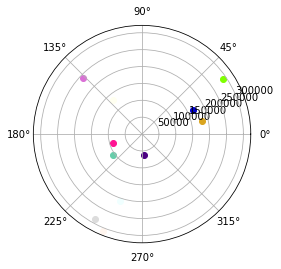

ddddddddddddddddddddddddddddddddd -3.6621143779134115
ddddddddddddddddddddddddddddddddd -18.929336870370804
ddddddddddddddddddddddddddddddddd -8.621661648529539
ddddddddddddddddddddddddddddddddd -0.6411611462238511
ddddddddddddddddddddddddddddddddd -1.7534707689173672
ddddddddddddddddddddddddddddddddd -6.72665989077592
ddddddddddddddddddddddddddddddddd -4.779784086373496
ddddddddddddddddddddddddddddddddd -1.816872491063549
ddddddddddddddddddddddddddddddddd -4.762706012559107
ddddddddddddddddddddddddddddddddd -1.9154626647037958
ddddddddddddddddddddddddddddddddd -3.634425192106363
ddddddddddddddddddddddddddddddddd -2.2459093277240925
ddddddddddddddddddddddddddddddddd -15.586967960146666
ddddddddddddddddddddddddddddddddd 0.2913282160632207
ddddddddddddddddddddddddddddddddd -38.25050154528296
ddddddddddddddddddddddddddddddddd -12.799013480445723
ddddddddddddddddddddddddddddddddd 2.840012106584055
ddddddddddddddddddddddddddddddddd -0.26092999334062483
ddddddddddddddddddddddddddddddddd -3.2

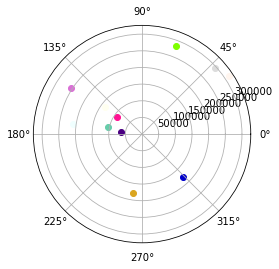

ddddddddddddddddddddddddddddddddd -3.6542645795573208
ddddddddddddddddddddddddddddddddd -20.207416846160044
ddddddddddddddddddddddddddddddddd -9.609709124940565
ddddddddddddddddddddddddddddddddd -0.9496944890259726
ddddddddddddddddddddddddddddddddd -1.631394505503323
ddddddddddddddddddddddddddddddddd -7.274881693737996
ddddddddddddddddddddddddddddddddd -5.232778383509441
ddddddddddddddddddddddddddddddddd -1.7140540552553034
ddddddddddddddddddddddddddddddddd -5.436336005459651
ddddddddddddddddddddddddddddddddd -2.1835031532459084
ddddddddddddddddddddddddddddddddd -3.7647311606521328
ddddddddddddddddddddddddddddddddd -2.165942788549586
ddddddddddddddddddddddddddddddddd -16.41205839237037
ddddddddddddddddddddddddddddddddd 0.10881340542897533
ddddddddddddddddddddddddddddddddd -39.18874103907615
ddddddddddddddddddddddddddddddddd -13.97239051774011
ddddddddddddddddddddddddddddddddd 2.784032906368793
ddddddddddddddddddddddddddddddddd -0.32836931281372017
ddddddddddddddddddddddddddddddddd -3.3

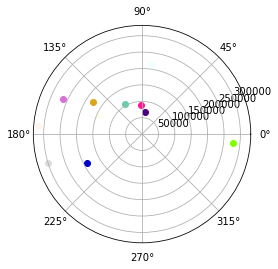

ddddddddddddddddddddddddddddddddd -3.6481659694970006
ddddddddddddddddddddddddddddddddd -21.493267920604637
ddddddddddddddddddddddddddddddddd -10.587491978102008
ddddddddddddddddddddddddddddddddd -1.282505103811161
ddddddddddddddddddddddddddddddddd -1.5128228611416716
ddddddddddddddddddddddddddddddddd -7.822567898326213
ddddddddddddddddddddddddddddddddd -5.68588534966932
ddddddddddddddddddddddddddddddddd -1.6136261765737743
ddddddddddddddddddddddddddddddddd -6.110030079427617
ddddddddddddddddddddddddddddddddd -2.4511214656535856
ddddddddddddddddddddddddddddddddd -3.9093135583319736
ddddddddddddddddddddddddddddddddd -2.093708006621455
ddddddddddddddddddddddddddddddddd -17.223426213593143
ddddddddddddddddddddddddddddddddd -0.07442067729996893
ddddddddddddddddddddddddddddddddd -40.07341899698281
ddddddddddddddddddddddddddddddddd -15.129380520050574
ddddddddddddddddddddddddddddddddd 2.7270777048422303
ddddddddddddddddddddddddddddddddd -0.4247247677751034
ddddddddddddddddddddddddddddddddd -

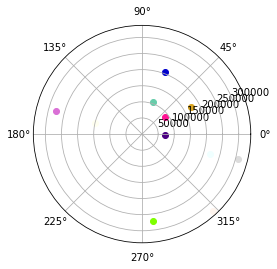

ddddddddddddddddddddddddddddddddd -3.6438430892957
ddddddddddddddddddddddddddddddddd -22.784182313716883
ddddddddddddddddddddddddddddddddd -11.554561062432612
ddddddddddddddddddddddddddddddddd -1.634490339048682
ddddddddddddddddddddddddddddddddd -1.3979000860891801
ddddddddddddddddddddddddddddddddd -8.369635699881172
ddddddddddddddddddddddddddddddddd -6.139059367100856
ddddddddddddddddddddddddddddddddd -1.515594206698438
ddddddddddddddddddddddddddddddddd -6.782182206865031
ddddddddddddddddddddddddddddddddd -2.718302994640112
ddddddddddddddddddddddddddddddddd -4.067449152028502
ddddddddddddddddddddddddddddddddd -2.0295289206860048
ddddddddddddddddddddddddddddddddd -18.02113483367637
ddddddddddddddddddddddddddddddddd -0.2583700415416956
ddddddddddddddddddddddddddddddddd -40.90882389624517
ddddddddddddddddddddddddddddddddd -16.26947896518982
ddddddddddddddddddddddddddddddddd 2.6692632220691337
ddddddddddddddddddddddddddddddddd -0.5477519248156852
ddddddddddddddddddddddddddddddddd -3.68985

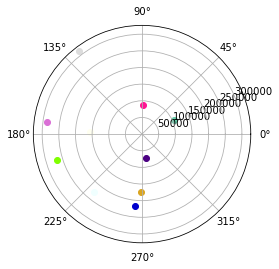

ddddddddddddddddddddddddddddddddd -3.6413194877164017
ddddddddddddddddddddddddddddddddd -24.077669242259304
ddddddddddddddddddddddddddddddddd -12.510529548534322
ddddddddddddddddddddddddddddddddd -2.001502784742371
ddddddddddddddddddddddddddddddddd -1.2867763201918194
ddddddddddddddddddddddddddddddddd -8.91600290285649
ddddddddddddddddddddddddddddddddd -6.592254782007785
ddddddddddddddddddddddddddddddddd -1.4199649262318417
ddddddddddddddddddddddddddddddddd -7.451567847383217
ddddddddddddddddddddddddddddddddd -2.985034144060336
ddddddddddddddddddddddddddddddddd -4.238397033389134
ddddddddddddddddddddddddddddddddd -1.9737113202523346
ddddddddddddddddddddddddddddddddd -18.805265745754383
ddddddddddddddddddddddddddddddddd -0.4430313825513963
ddddddddddddddddddddddddddddddddd -41.69883786214663
ddddddddddddddddddddddddddddddddd -17.392248790410264
ddddddddddddddddddddddddddddddddd 2.6106903542086
ddddddddddddddddddddddddddddddddd -0.6949689359635158
ddddddddddddddddddddddddddddddddd -3.876

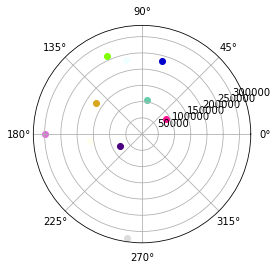

ddddddddddddddddddddddddddddddddd -3.6406176796327827
ddddddddddddddddddddddddddddddddd -25.37142571503105
ddddddddddddddddddddddddddddddddd -13.455063566058328
ddddddddddddddddddddddddddddddddd -2.380205353885941
ddddddddddddddddddddddddddddddddd -1.179607175112352
ddddddddddddddddddddddddddddddddd -9.461587995229905
ddddddddddddddddddddddddddddddddd -7.045425931067427
ddddddddddddddddddddddddddddddddd -1.3267465014066886
ddddddddddddddddddddddddddddddddd -8.117240479365847
ddddddddddddddddddddddddddddddddd -3.251302163723011
ddddddddddddddddddddddddddddddddd -4.4214116019714425
ddddddddddddddddddddddddddddddddd -1.9265377484471173
ddddddddddddddddddddddddddddddddd -19.57591694822952
ddddddddddddddddddddddddddddddddd -0.6284019449615244
ddddddddddddddddddddddddddddddddd -42.44697788133263
ddddddddddddddddddddddddddddddddd -18.49731808599094
ddddddddddddddddddddddddddddddddd 2.5514465123891057
ddddddddddddddddddddddddddddddddd -0.8638110555214951
ddddddddddddddddddddddddddddddddd -4.07

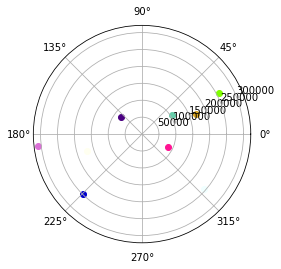

ddddddddddddddddddddddddddddddddd -3.641759073122813
ddddddddddddddddddddddddddddddddd -26.663315458477257
ddddddddddddddddddddddddddddddddd -14.38787562715936
ddddddddddddddddddddddddddddddddd -2.767923537703325
ddddddddddddddddddddddddddddddddd -1.0765531521752791
ddddddddddddddddddddddddddddddddd -10.006310230795805
ddddddddddddddddddddddddddddddddd -7.498527177850292
ddddddddddddddddddddddddddddddddd -1.235948396780401
ddddddddddddddddddddddddddddddddd -8.778460007665444
ddddddddddddddddddddddddddddddddd -3.517095024383508
ddddddddddddddddddddddddddddddddd -4.615753570631938
ddddddddddddddddddddddddddddddddd -1.8882624310148515
ddddddddddddddddddddddddddddddddd -20.33320145617523
ddddddddddddddddddddddddddddddddd -0.81447941979701
ddddddddddddddddddddddddddddddddd -43.156433187054006
ddddddddddddddddddddddddddddddddd -19.584377581798805
ddddddddddddddddddddddddddddddddd 2.491607615043449
ddddddddddddddddddddddddddddddddd -1.051755218288406
ddddddddddddddddddddddddddddddddd -4.28541

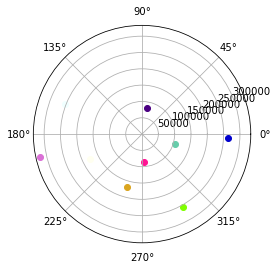

ddddddddddddddddddddddddddddddddd -3.6447639238022873
ddddddddddddddddddddddddddddddddd -27.95135369524806
ddddddddddddddddddddddddddddddddd -15.308719749945055
ddddddddddddddddddddddddddddddddd -3.1625136258356576
ddddddddddddddddddddddddddddddddd -0.977778891677815
ddddddddddddddddddddddddddddddddd -10.550089696029517
ddddddddddddddddddddddddddddddddd -7.951512940386067
ddddddddddddddddddddddddddddddddd -1.1475813082538195
ddddddddddddddddddddddddddddddddd -9.434642305864656
ddddddddddddddddddddddddddddddddd -3.7824013114482113
ddddddddddddddddddddddddddddddddd -4.820698939751452
ddddddddddddddddddddddddddddddddd -1.8591064522876195
ddddddddddddddddddddddddddddddddd -21.077245861621236
ddddddddddddddddddddddddddddddddd -1.0012618559864848
ddddddddddddddddddddddddddddddddd -43.83009891265891
ddddddddddddddddddddddddddddddddd -20.65317788881117
ddddddddddddddddddddddddddddddddd 2.4312397830611303
ddddddddddddddddddddddddddddddddd -1.2564087950404428
ddddddddddddddddddddddddddddddddd -4

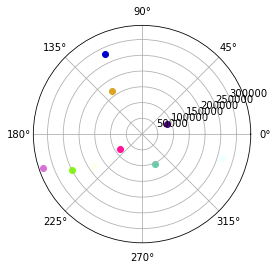

ddddddddddddddddddddddddddddddddd -3.6496512941769197
ddddddddddddddddddddddddddddddddd -29.23369618607967
ddddddddddddddddddddddddddddddddd -16.217387694698232
ddddddddddddddddddddddddddddddddd -3.562252724174357
ddddddddddddddddddddddddddddddddd -0.8834522190520033
ddddddddddddddddddddddddddddddddd -11.092847382214558
ddddddddddddddddddddddddddddddddd -8.404337714225363
ddddddddddddddddddddddddddddddddd -1.0616570719737695
ddddddddddddddddddddddddddddddddd -10.085323064876206
ddddddddddddddddddddddddddddddddd -4.047210143459381
ddddddddddddddddddddddddddddddddd -5.035546008289629
ddddddddddddddddddddddddddddddddd -1.8392533601993932
ddddddddddddddddddddddddddddddddd -21.80818897706601
ddddddddddddddddddddddddddddddddd -1.1887475925556146
ddddddddddddddddddddddddddddddddd -44.470606310632775
ddddddddddddddddddddddddddddddddd -21.703526558905452
ddddddddddddddddddddddddddddddddd 2.3704007716866613
ddddddddddddddddddddddddddddddddd -1.475564386745475
ddddddddddddddddddddddddddddddddd -4

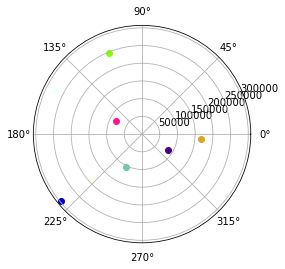

ddddddddddddddddddddddddddddddddd -3.6564390068356545
ddddddddddddddddddddddddddddddddd -30.508631299440736
ddddddddddddddddddddddddddddddddd -17.11370591344442
ddddddddddddddddddddddddddddddddd -3.9657502106526863
ddddddddddddddddddddddddddddddddd -0.7937429767065112
ddddddddddddddddddddddddddddddddd -11.634505252517584
ddddddddddddddddddddddddddddddddd -8.85695610681853
ddddddddddddddddddddddddddddddddd -0.9781885600042415
ddddddddddddddddddddddddddddddddd -10.730131468094015
ddddddddddddddddddddddddddddddddd -4.311511106840072
ddddddddddddddddddddddddddddddddd -5.259620583318281
ddddddddddddddddddddddddddddddddd -1.828845407338406
ddddddddddddddddddddddddddddddddd -22.526180550719204
ddddddddddddddddddddddddddddddddd -1.3769352042671699
ddddddddddddddddddddddddddddddddd -45.08034979948039
ddddddddddddddddddddddddddddddddd -22.735284983479545
ddddddddddddddddddddddddddddddddd 2.309141179864781
ddddddddddddddddddddddddddddddddd -1.707226785877225
ddddddddddddddddddddddddddddddddd -4.9

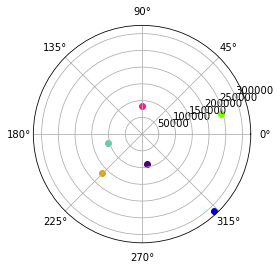

ddddddddddddddddddddddddddddddddd -3.6651436052333963
ddddddddddddddddddddddddddddddddd -31.77457416810779
ddddddddddddddddddddddddddddddddd -17.99753296904362
ddddddddddddddddddddddddddddddddd -4.371877826387447
ddddddddddddddddddddddddddddddddd -0.7088216318574325
ddddddddddddddddddddddddddddddddd -12.174986318749575
ddddddddddddddddddddddddddddddddd -9.309322866754144
ddddddddddddddddddddddddddddddddd -0.8971895667205843
ddddddddddddddddddddddddddddddddd -11.368770718607465
ddddddddddddddddddddddddddddddddd -4.5752942022066065
ddddddddddddddddddddddddddddddddd -5.49227960097403
ddddddddddddddddddddddddddddddddd -1.8279806321602052
ddddddddddddddddddddddddddddddddd -23.231380049269234
ddddddddddddddddddddddddddddddddd -1.5658234565599685
ddddddddddddddddddddddddddddddddd -45.661511120960284
ddddddddddddddddddddddddddddddddd -23.74836517327182
ddddddddddddddddddddddddddddddddd 2.24750547185738
ddddddddddddddddddddddddddddddddd -1.949619541711428
ddddddddddddddddddddddddddddddddd -5.21

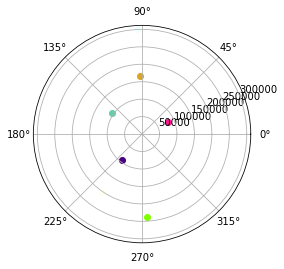

ddddddddddddddddddddddddddddddddd -3.675780318896443
ddddddddddddddddddddddddddddddddd -33.03006222290813
ddddddddddddddddddddddddddddddddd -18.86875727347399
ddddddddddddddddddddddddddddddddd -4.779715025368915
ddddddddddddddddddddddddddddddddd -0.6288576543744853
ddddddddddddddddddddddddddddddddd -12.714214699406085
ddddddddddddddddddddddddddddddddd -9.761392912769736
ddddddddddddddddddddddddddddddddd -0.8186746822113093
ddddddddddddddddddddddddddddddddd -12.00100342151643
ddddddddddddddddddddddddddddddddd -4.838549800475789
ddddddddddddddddddddddddddddddddd -5.732913394878921
ddddddddddddddddddddddddddddddddd -1.836710900237847
ddddddddddddddddddddddddddddddddd -23.923955510089
ddddddddddddddddddddddddddddddddd -1.7554112684908887
ddddddddddddddddddddddddddddddddd -46.21608089286147
ddddddddddddddddddddddddddddddddd -24.742726472993922
ddddddddddddddddddddddddddddddddd 2.185532840331831
ddddddddddddddddddddddddddddddddd -2.201178029764151
ddddddddddddddddddddddddddddddddd -5.4691303

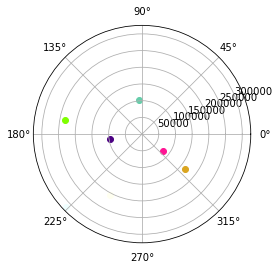

ddddddddddddddddddddddddddddddddd -3.688363033295758
ddddddddddddddddddddddddddddddddd -34.27375157057472
ddddddddddddddddddddddddddddddddd -19.727295047376515
ddddddddddddddddddddddddddddddddd -5.1885064213331304
ddddddddddddddddddddddddddddddddd -0.5540176687893279
ddddddddddddddddddddddddddddddddd -13.252115679286618
ddddddddddddddddddddddddddddddddd -10.213121362489858
ddddddddddddddddddddddddddddddddd -0.7426591552054731
ddddddddddddddddddddddddddddddddd -12.626640455089614
ddddddddddddddddddddddddddddddddd -5.101268606757003
ddddddddddddddddddddddddddddddddd -5.980946849724347
ddddddddddddddddddddddddddddddddd -1.855041024772845
ddddddddddddddddddddddddddddddddd -24.604082462069698
ddddddddddddddddddddddddddddddddd -1.9456976820393947
ddddddddddddddddddddddddddddddddd -46.74587782914003
ddddddddddddddddddddddddddddddddd -25.718372197989027
ddddddddddddddddddddddddddddddddd 2.1232579363552873
ddddddddddddddddddddddddddddddddd -2.4605345679191544
ddddddddddddddddddddddddddddddddd -

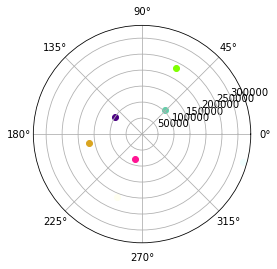

ddddddddddddddddddddddddddddddddd -3.7029042645947357
ddddddddddddddddddddddddddddddddd -35.50441382131862
ddddddddddddddddddddddddddddddddd -20.573088437919296
ddddddddddddddddddddddddddddddddd -5.597628659954182
ddddddddddddddddddddddddddddddddd -0.484463393671831
ddddddddddddddddddddddddddddddddd -13.788615772515527
ddddddddddddddddddddddddddddddddd -10.664463560845519
ddddddddddddddddddddddddddddddddd -0.6691587308070268
ddddddddddddddddddddddddddddddddd -13.245532383205244
ddddddddddddddddddddddddddddddddd -5.363441630474853
ddddddddddddddddddddddddddddddddd -6.235839664203155
ddddddddddddddddddddddddddddddddd -1.8829290156325555
ddddddddddddddddddddddddddddddddd -25.27194291399067
ddddddddddddddddddddddddddddddddd -2.1366818365082167
ddddddddddddddddddddddddddddddddd -47.25256586305733
ddddddddddddddddddddddddddddddddd -26.6753463045749
ddddddddddddddddddddddddddddddddd 2.0607114877585957
ddddddddddddddddddddddddddddddddd -2.7264996054426547
ddddddddddddddddddddddddddddddddd -5.9

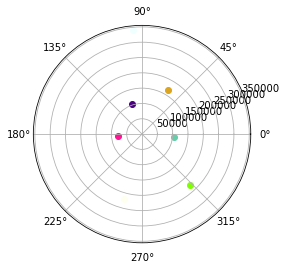

ddddddddddddddddddddddddddddddddd -3.719415139440599
ddddddddddddddddddddddddddddddddd -36.72093308026871
ddddddddddddddddddddddddddddddddd -21.406103754637343
ddddddddddddddddddddddddddddddddd -6.006564570339236
ddddddddddddddddddddddddddddddddd -0.4203493957765545
ddddddddddddddddddddddddddddddddd -14.323642779378872
ddddddddddddddddddddddddddddddddd -11.115375108129513
ddddddddddddddddddddddddddddddddd -0.5981894911588768
ddddddddddddddddddddddddddddddddd -13.857562742803111
ddddddddddddddddddddddddddddddddd -5.6250601600097525
ddddddddddddddddddddddddddddddddd -6.497085919945448
ddddddddddddddddddddddddddddddddd -1.920287427558634
ddddddddddddddddddddddddddddddddd -25.927724409038774
ddddddddddddddddddddddddddddddddd -2.328362947033014
ddddddddddddddddddddddddddddddddd -47.73766940502898
ddddddddddddddddddddddddddddddddd -27.613730079988414
ddddddddddddddddddddddddddddddddd 1.99792082392716
ddddddddddddddddddddddddddddddddd -2.9980416782864268
ddddddddddddddddddddddddddddddddd -6.2

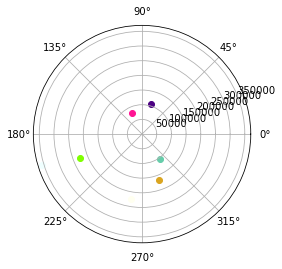

ddddddddddddddddddddddddddddddddd -3.737905379921841
ddddddddddddddddddddddddddddddddd -37.92230290146935
ddddddddddddddddddddddddddddddddd -22.226329797639096
ddddddddddddddddddddddddddddddddd -6.414882918881688
ddddddddddddddddddddddddddddddddd -0.3618206997993525
ddddddddddddddddddddddddddddddddd -14.85712584033655
ddddddddddddddddddddddddddddddddd -11.565811887645623
ddddddddddddddddddddddddddddddddd -0.5297676709597567
ddddddddddddddddddddddddddddddddd -14.46264273172946
ddddddddddddddddddddddddddddddddd -5.886115742041227
ddddddddddddddddddddddddddddddddd -6.764213156602523
ddddddddddddddddddddddddddddddddd -1.966985733257843
ddddddddddddddddddddddddddddddddd -26.571619143814246
ddddddddddddddddddddddddddddddddd -2.5207402864263884
ddddddddddddddddddddddddddddddddd -48.20258698232277
ddddddddddddddddddddddddddddddddd -28.533638892737486
ddddddddddddddddddddddddddddddddd 1.934910322362441
ddddddddddddddddddddddddddddddddd -3.2742677923261
ddddddddddddddddddddddddddddddddd -6.53185

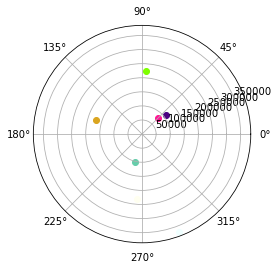

ddddddddddddddddddddddddddddddddd -3.758383286192668
ddddddddddddddddddddddddddddddddd -39.10762308300045
ddddddddddddddddddddddddddddddddd -23.033776262227292
ddddddddddddddddddddddddddddddddd -6.822222474404896
ddddddddddddddddddddddddddddddddd -0.30901030778241534
ddddddddddddddddddddddddddddddddd -15.388995487127886
ddddddddddddddddddddddddddddddddd -12.015730092908257
ddddddddddddddddddddddddddddddddd -0.46390945889206137
ddddddddddddddddddddddddddddddddd -15.060706954785019
ddddddddddddddddddddddddddddddddd -6.146600167259123
ddddddddddddddddddddddddddddddddd -7.03678104895809
ddddddddddddddddddddddddddddddddd -2.0228535910028143
ddddddddddddddddddddddddddddddddd -27.20382315559749
ddddddddddddddddddddddddddddddddd -2.7138131697064978
ddddddddddddddddddddddddddddddddd -48.64860336991478
ddddddddddddddddddddddddddddddddd -29.43521902843395
ddddddddddddddddddddddddddddddddd 1.8717017893237937
ddddddddddddddddddddddddddddddddd -3.5544051625276154
ddddddddddddddddddddddddddddddddd -6

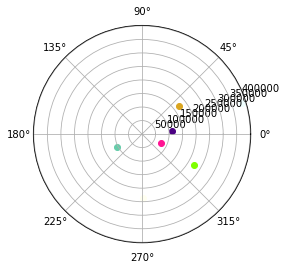

ddddddddddddddddddddddddddddddddd -3.7808557533331566
ddddddddddddddddddddddddddddddddd -40.276096211028374
ddddddddddddddddddddddddddddddddd -23.828472210301527
ddddddddddddddddddddddddddddddddd -7.228279398936564
ddddddddddddddddddddddddddddddddd -0.2620366964310108
ddddddddddddddddddddddddddddddddd -15.91918369090331
ddddddddddddddddddddddddddddddddd -12.465086254352627
ddddddddddddddddddddddddddddddddd -0.40063078772755034
ddddddddddddddddddddddddddddddddd -15.65170997965879
ddddddddddddddddddddddddddddddddd -6.4065054505929595
ddddddddddddddddddddddddddddddddd -7.314379857399501
ddddddddddddddddddddddddddddddddd -2.0876848364419516
ddddddddddddddddddddddddddddddddd -27.824535546329372
ddddddddddddddddddddddddddddddddd -2.90758094093664
ddddddddddddddddddddddddddddddddd -49.07690043543995
ddddddddddddddddddddddddddddddddd -30.318644631986217
ddddddddddddddddddddddddddddddddd 1.8083147852116213
ddddddddddddddddddddddddddddddddd -3.8377847479830507
ddddddddddddddddddddddddddddddddd -

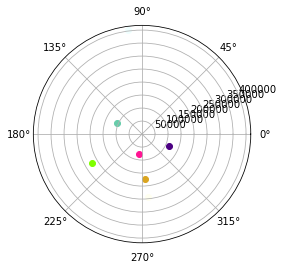

ddddddddddddddddddddddddddddddddd -3.8053282521444203
ddddddddddddddddddddddddddddddddd -41.42702392065107
ddddddddddddddddddddddddddddddddd -24.610464602053156
ddddddddddddddddddddddddddddddddd -7.632797209800287
ddddddddddddddddddddddddddddddddd -0.22100137246960116
ddddddddddddddddddddddddddddddddd -16.447623906701295
ddddddddddddddddddddddddddddddddd -12.913837264752033
ddddddddddddddddddddddddddddddddd -0.3399471130786935
ddddddddddddddddddddddddddddddddd -16.235623513275414
ddddddddddddddddddddddddddddddddd -6.665823820487361
ddddddddddddddddddddddddddddddddd -7.596628724490785
ddddddddddddddddddddddddddddddddd -2.1612420040716813
ddddddddddddddddddddddddddddddddd -28.43395780228815
ddddddddddddddddddddddddddddddddd -3.102042961526905
ddddddddddddddddddddddddddddddddd -49.488566829182986
ddddddddddddddddddddddddddddddddd -31.184114772032814
ddddddddddddddddddddddddddddddddd 1.7447669035529145
ddddddddddddddddddddddddddddddddd -4.1238267172957705
ddddddddddddddddddddddddddddddddd 

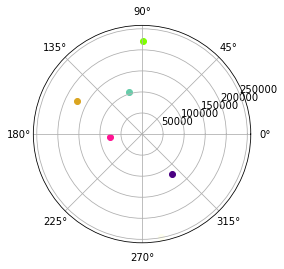

ddddddddddddddddddddddddddddddddd -3.8318048383270025
ddddddddddddddddddddddddddddddddd -42.55980286858852
ddddddddddddddddddddddddddddddddd -25.37981688729562
ddddddddddddddddddddddddddddddddd -8.035558741162077
ddddddddddddddddddddddddddddddddd -0.1859865731030368
ddddddddddddddddddddddddddddddddd -16.974251115661588
ddddddddddddddddddddddddddddddddd -13.361940404404692
ddddddddddddddddddddddddddddddddd -0.28187317929865685
ddddddddddddddddddddddddddddddddd -16.812434067554392
ddddddddddddddddddddddddddddddddd -6.924547708321597
ddddddddddddddddddddddddddddddddd -7.883173894677668
ddddddddddddddddddddddddddddddddd -2.243261173315517
ddddddddddddddddddddddddddddddddd -29.03229314223549
ddddddddddddddddddddddddddddddddd -3.2971986005122744
ddddddddddddddddddddddddddddddddd -49.88460665260516
ddddddddddddddddddddddddddddddddd -32.031850642980515
ddddddddddddddddddddddddddddddddd 1.6810740105355535
ddddddddddddddddddddddddddddddddd -4.412027801383317
ddddddddddddddddddddddddddddddddd -7.

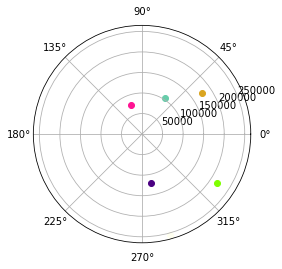

ddddddddddddddddddddddddddddddddd -3.860288165875545
ddddddddddddddddddddddddddddddddd -43.673920433571084
ddddddddddddddddddddddddddddddddd -26.136607654582548
ddddddddddddddddddddddddddddddddd -8.436379670336635
ddddddddddddddddddddddddddddddddd -0.1570532034922394
ddddddddddddddddddddddddddddddddd -17.499001864635716
ddddddddddddddddddddddddddddddddd -13.809353367864958
ddddddddddddddddddddddddddddddddd -0.22642277481969586
ddddddddddddddddddddddddddddddddd -17.38214101015808
ddddddddddddddddddddddddddddddddd -7.182669739652198
ddddddddddddddddddddddddddddddddd -8.173686915336162
ddddddddddddddddddddddddddddddddd -2.333456941927807
ddddddddddddddddddddddddddddddddd -29.619745927252893
ddddddddddddddddddddddddddddddddd -3.4930472264198897
ddddddddddddddddddddddddddddddddd -50.26594722079206
ddddddddddddddddddddddddddddddddd -32.8620929136745
ddddddddddddddddddddddddddddddddd 1.6172504512623505
ddddddddddddddddddddddddddddddddd -4.701950392055011
ddddddddddddddddddddddddddddddddd -7.9

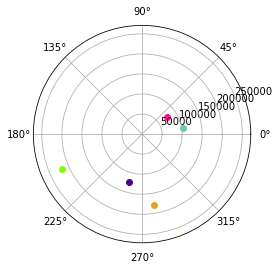

ddddddddddddddddddddddddddddddddd -3.8907795040461792
ddddddddddddddddddddddddddddddddd -44.768950175450954
ddddddddddddddddddddddddddddddddd -26.880929335297225
ddddddddddddddddddddddddddddddddd -8.835103269690762
ddddddddddddddddddddddddddddddddd -0.13423910185323962
ddddddddddddddddddddddddddddddddd -18.02181430158157
ddddddddddddddddddddddddddddddddd -14.2560342876412
ddddddddddddddddddddddddddddddddd -0.17360848442166343
ddddddddddddddddddddddddddddddddd -17.944754918942436
ddddddddddddddddddddddddddddddddd -7.440182726114415
ddddddddddddddddddddddddddddddddd -8.46786286091637
ddddddddddddddddddddddddddddddddd -2.431527348668965
ddddddddddddddddddddddddddddddddd -30.19652111968736
ddddddddddddddddddddddddddddddddd -3.6895881995813227
ddddddddddddddddddddddddddddddddd -50.63344601891562
ddddddddddddddddddddddddddddddddd -33.67509922673139
ddddddddddddddddddddddddddddddddd 1.5533092281248457
ddddddddddddddddddddddddddddddddd -4.993213207937714
ddddddddddddddddddddddddddddddddd -8.23

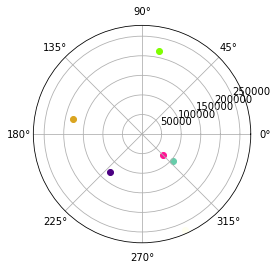

ddddddddddddddddddddddddddddddddd -3.923278758199615
ddddddddddddddddddddddddddddddddd -45.84454709819309
ddddddddddddddddddddddddddddddddd -27.612886965082765
ddddddddddddddddddddddddddddddddd -9.231596128035392
ddddddddddddddddddddddddddddddddd -0.11755771208353849
ddddddddddddddddddddddddddddddddd -18.542628208190024
ddddddddddddddddddddddddddddddddd -14.701941757850335
ddddddddddddddddddddddddddddddddd -0.1234414267692614
ddddddddddddddddddddddddddddddddd -18.500296182128068
ddddddddddddddddddddddddddddddddd -7.697079658606896
ddddddddddddddddddddddddddddddddd -8.765418610561142
ddddddddddddddddddddddddddddddddd -2.5371585919436086
ddddddddddddddddddddddddddddddddd -30.762823790528785
ddddddddddddddddddddddddddddddddd -3.886820865568154
ddddddddddddddddddddddddddddddddd -50.9878969456627
ddddddddddddddddddddddddddddddddd -34.471141854568344
ddddddddddddddddddddddddddddddddd 1.489262155205438
ddddddddddddddddddddddddddddddddd -5.285483333772703
ddddddddddddddddddddddddddddddddd -8.5

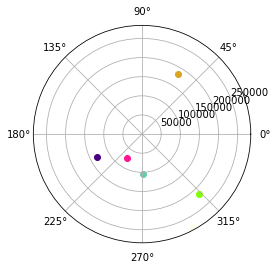

ddddddddddddddddddddddddddddddddd -3.9577844952101486
ddddddddddddddddddddddddddddddddd -46.900442766167686
ddddddddddddddddddddddddddddddddd -28.33259700227103
ddddddddddddddddddddddddddddddddd -9.625744641767767
ddddddddddddddddddddddddddddddddd -0.10699723095527247
ddddddddddddddddddddddddddddddddd -19.06138502926177
ddddddddddddddddddddddddddddddddd -15.147034857223474
ddddddddddddddddddddddddddddddddd -0.0759310022477564
ddddddddddddddddddddddddddddddddd -19.04879379730363
ddddddddddddddddddddddddddddddddd -7.953353701369622
ddddddddddddddddddddddddddddddddd -9.066091199727282
ddddddddddddddddddddddddddddddddd -2.6500294248646696
ddddddddddddddddddddddddddddddddd -31.318858671991677
ddddddddddddddddddddddddddddddddd -4.084744549388489
ddddddddddddddddddddddddddddddddd -51.330035929047284
ddddddddddddddddddddddddddddddddd -35.250505512842295
ddddddddddddddddddddddddddddddddd 1.4251199923411662
ddddddddddddddddddddddddddddddddd -5.578469446888164
ddddddddddddddddddddddddddddddddd -8

KeyboardInterrupt: 

In [95]:
ss = obs_target

prop_cc(ss, more_eph, r, v, dir_o_tele, 1)


In [50]:
savedata = np.load('savedata1.npy')

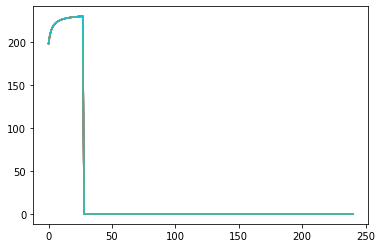

In [91]:
import matplotlib.pyplot as plt
plt.figure()
for i in range(10):
    plt.plot(savedata[9,:,2])
plt.show()

In [97]:
a = [[1,2,3,4,5],[1,2,3,4,7]]
a[0][:-1]

[1, 2, 3, 4]

In [27]:
cnames = {
    'aliceblue': '#F0F8FF',
    'aqua': '#00FFFF',
    'aquamarine': '#7FFFD4',
    'azure': '#F0FFFF',
    'beige': '#F5F5DC',
    'bisque': '#FFE4C4',
    'black': '#000000',
    'blanchedalmond': '#FFEBCD',
    'blue': '#0000FF',
    'blueviolet': '#8A2BE2',
    'brown': '#A52A2A',
    'burlywood': '#DEB887',
    'cadetblue': '#5F9EA0',
    'chartreuse': '#7FFF00',
    'chocolate': '#D2691E',
    'coral': '#FF7F50',
    'cornflowerblue': '#6495ED',
    'cornsilk': '#FFF8DC',
    'crimson': '#DC143C',
    'cyan': '#00FFFF',
    'darkblue': '#00008B',
    'darkcyan': '#008B8B',
    'darkgoldenrod': '#B8860B',
    'darkgray': '#A9A9A9',
    'darkgreen': '#006400',
    'darkkhaki': '#BDB76B',
    'darkmagenta': '#8B008B',
    'darkolivegreen': '#556B2F',
    'darkorange': '#FF8C00',
    'darkorchid': '#9932CC',
    'darkred': '#8B0000',
    'darksalmon': '#E9967A',
    'darkseagreen': '#8FBC8F',
    'darkslateblue': '#483D8B',
    'darkslategray': '#2F4F4F',
    'darkturquoise': '#00CED1',
    'darkviolet': '#9400D3',
    'deeppink': '#FF1493',
    'deepskyblue': '#00BFFF',
    'dimgray': '#696969',
    'dodgerblue': '#1E90FF',
    'firebrick': '#B22222',
    'floralwhite': '#FFFAF0',
    'forestgreen': '#228B22',
    'fuchsia': '#FF00FF',
    'gainsboro': '#DCDCDC',
    'ghostwhite': '#F8F8FF',
    'gold': '#FFD700',
    'goldenrod': '#DAA520',
    'gray': '#808080',
    'green': '#008000',
    'greenyellow': '#ADFF2F',
    'honeydew': '#F0FFF0',
    'hotpink': '#FF69B4',
    'indianred': '#CD5C5C',
    'indigo': '#4B0082',
    'ivory': '#FFFFF0',
    'khaki': '#F0E68C',
    'lavender': '#E6E6FA',
    'lavenderblush': '#FFF0F5',
    'lawngreen': '#7CFC00',
    'lemonchiffon': '#FFFACD',
    'lightblue': '#ADD8E6',
    'lightcoral': '#F08080',
    'lightcyan': '#E0FFFF',
    'lightgoldenrodyellow': '#FAFAD2',
    'lightgreen': '#90EE90',
    'lightgray': '#D3D3D3',
    'lightpink': '#FFB6C1',
    'lightsalmon': '#FFA07A',
    'lightseagreen': '#20B2AA',
    'lightskyblue': '#87CEFA',
    'lightslategray': '#778899',
    'lightsteelblue': '#B0C4DE',
    'lightyellow': '#FFFFE0',
    'lime': '#00FF00',
    'limegreen': '#32CD32',
    'linen': '#FAF0E6',
    'magenta': '#FF00FF',
    'maroon': '#800000',
    'mediumaquamarine': '#66CDAA',
    'mediumblue': '#0000CD',
    'mediumorchid': '#BA55D3',
    'mediumpurple': '#9370DB',
    'mediumseagreen': '#3CB371',
    'mediumslateblue': '#7B68EE',
    'mediumspringgreen': '#00FA9A',
    'mediumturquoise': '#48D1CC',
    'mediumvioletred': '#C71585',
    'midnightblue': '#191970',
    'mintcream': '#F5FFFA',
    'mistyrose': '#FFE4E1',
    'moccasin': '#FFE4B5',
    'navajowhite': '#FFDEAD',
    'navy': '#000080',
    'oldlace': '#FDF5E6',
    'olive': '#808000',
    'olivedrab': '#6B8E23',
    'orange': '#FFA500',
    'orangered': '#FF4500',
    'orchid': '#DA70D6',
    'palegoldenrod': '#EEE8AA',
    'palegreen': '#98FB98',
    'paleturquoise': '#AFEEEE',
    'palevioletred': '#DB7093',
    'papayawhip': '#FFEFD5',
    'peachpuff': '#FFDAB9',
    'peru': '#CD853F',
    'pink': '#FFC0CB',
    'plum': '#DDA0DD',
    'powderblue': '#B0E0E6',
    'purple': '#800080',
    'red': '#FF0000',
    'rosybrown': '#BC8F8F',
    'royalblue': '#4169E1',
    'saddlebrown': '#8B4513',
    'salmon': '#FA8072',
    'sandybrown': '#FAA460',
    'seagreen': '#2E8B57',
    'seashell': '#FFF5EE',
    'sienna': '#A0522D',
    'silver': '#C0C0C0',
    'skyblue': '#87CEEB',
    'slateblue': '#6A5ACD',
    'slategray': '#708090',
    'snow': '#FFFAFA',
    'springgreen': '#00FF7F',
    'steelblue': '#4682B4',
    'tan': '#D2B48C',
    'teal': '#008080',
    'thistle': '#D8BFD8',
    'tomato': '#FF6347',
    'turquoise': '#40E0D0',
    'violet': '#EE82EE',
    'wheat': '#F5DEB3',
    'yellow': '#FFFF00',
    'yellowgreen': '#9ACD32'}

# colorname = ['black', 'blue', 'brown', 'yellowgreen', 'yellow', 'deeppink', 'red', 'purple', 'orange', 'darkseagreen',
#              'green', 'wheat', 'burlywood', 'cadetblue']

# print(cnames[colorname[1]])
# cnames

# dict1 = {"A": "11", "B": "22", "C": "33"}



colorname = []
for everyKey in cnames.keys():
    colorname.append(everyKey)

random.shuffle(colorname)


In [81]:
random.choice((-1,1))*random.uniform(-5, -4)

-4.2661737662329475